# Preprocessing ERASMUS Glioma Dataset
Now, let's do this one last time!

The goal of this file is to create tfrecord files of the ERASMUS Glioma dataset, that can be used for training. The result should be tfrecord files for each leasion with a label indication what kind of tumor is visible in the leasion.

Citation: Sebastian R. van der Voort, Fatih Incekara, Maarten M.J. Wijnenga, Georgios Kapsas, Renske Gahrmann, Joost W. Schouten, Hendrikus J. Dubbink, Arnaud J.P.E. Vincent, Martin J. van den Bent, Pim J. French, Stefan Klein, Marion Smits,
The Erasmus Glioma Database (EGD): Structural MRI scans, WHO 2016 subtypes, and segmentations of 774 patients with glioma,
Data in Brief,
Volume 37,
2021,
107191,
ISSN 2352-3409,
https://doi.org/10.1016/j.dib.2021.107191.
(https://www.sciencedirect.com/science/article/pii/S2352340921004753)

Infos about the dataset:
- the dataset contains images of different gliomas
- age and sex are included, as well as the IDH, 1p19q status and grade for each tumor, we will most likely use these last values to get the proper grading for each patient
- all the other information we'll ignore

The dataset structure looks like this:
```
path_to_egd_dataset_folder
│
│__MR_EGD-0001
    │
    │__1_T1
        │
        │__NIFTI
            │
            │__T1.nii.gz
    │__2_T1GD
        │
        │__NIFTI
            │
            │__T1GD.nii.gz
    │__3_T2
        │
        │__NIFTI
            │
            │__T2.nii.gz
    │__4_FLAIR
        │
        │__NIFTI
            │
            │__FLAIR.nii.gz
    │__5_MASK
        │
        │__NIFTI
            │
            │__MASK.nii.gz
│__MR_EGD-0002
│__MR_EGD-0003
...
```

In [ ]:
# TO-DO:
# [X] Get overview of dataset
# [X] Rotate images 90 degress, resize and percentile normalize them
# [X] Create png images of the largest visible tumor slice in each scan
# [X] Combine the four sequences and the segmentation mask into a single tfrecord file
# [ ] Profit?

Let's import all the libraries we'll need for the data preparation

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from pathlib import Path
import random
import nibabel as nib
from nipype.interfaces import fsl

Then we'll define the paths we'll be using in this notebook

In [2]:
path_to_egd_dataset_folder = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_manual')
path_to_selected_egd_dataset_folder = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected')
path_to_egd_genetic_data = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/egd_dataset_infos/resources/PROJECT_DATA/files/Genetic_and_Histological_labels.xlsx')
path_to_egd_png_slices = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_pngs')
path_to_egd_tfrs = Path('/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_tfrs')

path_to_egd_rgb_tfrs = path_to_egd_tfrs / 'rgb_tfrs'
path_to_egd_gray_tfrs = path_to_egd_tfrs / 'gray_tfrs'

IMG_SIZE = 240

In [3]:
# create custom class for each patient to store all relevant information

class Patient:
    def __init__(self, id):
        self.id = id

        self.t1 = None # Path to T1 image
        self.t1c = None # Path to T1c image
        self.t2 = None # Path to T2 image
        self.flair = None # Path to FLAIR image

        self.tumor_segmentation = None # Path to tumor segmentation mask

        self.classification = None # Number between 0 and 4 (for further information see below)

## Clean up dataset IDs
First let's get an overview over the dataset

In [4]:
egd_genetic_data = pd.read_excel(path_to_egd_genetic_data)
print("Number of patients: ", len(egd_genetic_data))
print(egd_genetic_data.value_counts('IDH'))
print(egd_genetic_data.value_counts('1p19q'))
print(egd_genetic_data.value_counts('Grade'))
egd_genetic_data.head()

Number of patients:  774
IDH
 0    312
-1    307
 1    155
Name: count, dtype: int64
1p19q
-1    515
 0    186
 1     73
Name: count, dtype: int64
Grade
 4    502
 2    135
 3     79
-1     58
Name: count, dtype: int64


,Subject,IDH,1p19q,Grade
0,EGD-0001,-1,-1,4
1,EGD-0002,-1,-1,2
2,EGD-0003,-1,-1,4
3,EGD-0004,1,1,2
4,EGD-0005,-1,-1,4


In [5]:
# we need to drop all patients where there's no information about the IDH, 1p19q status or grade
# meaning: we drop all the patients where the columns are -1
egd_genetic_data = egd_genetic_data[egd_genetic_data['IDH'] != -1]
egd_genetic_data = egd_genetic_data[egd_genetic_data['1p19q'] != -1]
egd_genetic_data = egd_genetic_data[egd_genetic_data['Grade'] != -1]
print(egd_genetic_data.value_counts('IDH'))
print(egd_genetic_data.value_counts('1p19q'))
print(egd_genetic_data.value_counts('Grade'))
print("New number of patients: ", len(egd_genetic_data))

IDH
1    136
0     86
Name: count, dtype: int64
1p19q
0    153
1     69
Name: count, dtype: int64
Grade
2    127
4     67
3     28
Name: count, dtype: int64
New number of patients:  222


### Converting WHO Glioma Classification 2016 to 2021
Our mapping logic goes like this:\
If IDH = mutant:\
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If 1q19q = codeleted -> Oligodendroglioma, IDH-mutant, 1p19q-codeleted\
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Else -> Astrocytome, IDH-mutant\
If IDH = wildtype:\
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If grade = 4 -> Glioblastoma, IDH-wildtype\
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Else grade = 2 or 3 -> Astrocytome, IDH-wildytpe

For the IDH mutation status and the 1p/19q co-deletion status patients have either label 1 (when the tumor was IDH mutated or 1p/19q co-deleted, respectively) or label 0 (when the tumor was IDH wildtype or 1p/19q intact, respectively)

The labels for the pretraining dataset are going to be:
- 0: Glioblastoma, IDH-wildtype
- 1: Astrocytoma, IDH-wildtype
- 2: Astrocytoma, IDH-mutant
- 3: Oligodendroglioma, IDH-mutant, 1p/19q-codeleted
- 4: brain metastases\
(there are no brain metastases in this dataset, so we can forget about those)

In [6]:
# iterate over each patient in the dataset and add a new column depending on the values of IDH, 1p19q and Grade

def assign_new_classification(row):
    if row["IDH"] == 1:
        if row["1p19q"] == 1:
            return 3 # Oligodendroglioma, IDH-mutant and 1p19q-codeleted
        elif row["1p19q"] == 0:
            return 2 # Astrocytoma, IDH-mutant
    elif row["IDH"] == 0:
        if row["Grade"] == 4:
            return 0 # Glioblastoma, IDH-wildtype
        elif (row["Grade"] == 2 or row["Grade"] == 3):
            return 1
    else:
        return -1

egd_genetic_data['classification'] = egd_genetic_data.apply(assign_new_classification, axis=1)

In [7]:
print(egd_genetic_data.value_counts('classification'))
egd_genetic_data.head()

classification
3    69
2    67
0    66
1    20
Name: count, dtype: int64


,Subject,IDH,1p19q,Grade,classification
3,EGD-0004,1,1,2,3
7,EGD-0008,1,1,2,3
8,EGD-0009,0,0,2,1
10,EGD-0011,1,1,2,3
13,EGD-0014,0,0,4,0


Isolate the patient IDs and their pathologies

In [8]:
# convert IDs and classes to dictionary for easy access
patients_ids_and_classes = egd_genetic_data.set_index("Subject")["classification"].to_dict()
print(patients_ids_and_classes)

{'EGD-0004': 3, 'EGD-0008': 3, 'EGD-0009': 1, 'EGD-0011': 3, 'EGD-0014': 0, 'EGD-0020': 3, 'EGD-0022': 3, 'EGD-0024': 2, 'EGD-0029': 2, 'EGD-0033': 3, 'EGD-0041': 1, 'EGD-0055': 0, 'EGD-0057': 3, 'EGD-0066': 3, 'EGD-0068': 3, 'EGD-0072': 2, 'EGD-0073': 0, 'EGD-0074': 2, 'EGD-0075': 0, 'EGD-0078': 3, 'EGD-0080': 0, 'EGD-0085': 0, 'EGD-0086': 2, 'EGD-0090': 2, 'EGD-0099': 1, 'EGD-0101': 2, 'EGD-0106': 2, 'EGD-0107': 2, 'EGD-0115': 0, 'EGD-0118': 2, 'EGD-0122': 2, 'EGD-0123': 3, 'EGD-0128': 2, 'EGD-0133': 3, 'EGD-0137': 3, 'EGD-0143': 3, 'EGD-0144': 0, 'EGD-0145': 2, 'EGD-0146': 3, 'EGD-0160': 2, 'EGD-0161': 1, 'EGD-0162': 3, 'EGD-0165': 0, 'EGD-0176': 0, 'EGD-0177': 3, 'EGD-0179': 3, 'EGD-0183': 0, 'EGD-0185': 2, 'EGD-0186': 3, 'EGD-0187': 3, 'EGD-0188': 2, 'EGD-0192': 0, 'EGD-0193': 0, 'EGD-0194': 3, 'EGD-0196': 0, 'EGD-0197': 0, 'EGD-0198': 0, 'EGD-0199': 3, 'EGD-0202': 0, 'EGD-0203': 2, 'EGD-0208': 2, 'EGD-0211': 2, 'EGD-0214': 3, 'EGD-0217': 3, 'EGD-0221': 3, 'EGD-0226': 0, 'EGD-0228

## Get Nifti and Segmentation Files for the IDs

In [9]:
all_patients = []
patients_with_missing_data = []

# loop through ids and create patient objects
for id in tqdm(patients_ids_and_classes.keys()):
    patient = Patient(id)

    path_patient_name = "MR_" + str(id)
    path_to_t1 = path_to_egd_dataset_folder / path_patient_name / "1_T1" / "NIFTI" / "T1.nii.gz"
    path_to_t1c = path_to_egd_dataset_folder / path_patient_name / "2_T1GD" / "NIFTI" / "T1GD.nii.gz"
    path_to_t2 = path_to_egd_dataset_folder / path_patient_name / "3_T2" / "NIFTI" / "T2.nii.gz"
    path_to_flair = path_to_egd_dataset_folder / path_patient_name / "4_FLAIR" / "NIFTI" / "FLAIR.nii.gz"
    path_to_segmentation = path_to_egd_dataset_folder / path_patient_name / "5_MASK" / "NIFTI" / "MASK.nii.gz"

    paths_to_files = [path_to_t1, path_to_t1c, path_to_t2, path_to_flair, path_to_segmentation]

    for path in paths_to_files:
        if not path.is_file():
            patients_with_missing_data.append(id)
            print(f"{path} for patient {id} does not exist")
            continue

    patient.t1 = path_to_t1
    patient.t1c = path_to_t1c
    patient.t2 = path_to_t2
    patient.flair = path_to_flair
    patient.tumor_segmentation = path_to_segmentation

    patient.classification = patients_ids_and_classes[id]

    all_patients.append(patient)

  0%|          | 0/222 [00:00<?, ?it/s]

100%|██████████| 222/222 [00:00<00:00, 2072.21it/s]


In [10]:
print(f"# of all patients: {len(all_patients)}")

# of all patients: 222


Display 9 random images from all patients including the segmentations

In [11]:
def visualize_random_patients(all_patients):

    # Funktion zum Laden und Anzeigen eines NIfTI-Bildes
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    # 9 zufällige Patienten auswählen
    random_patients = random.sample(all_patients, 9)

    # 3x3 Grafik erstellen
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, patient in enumerate(random_patients):
        ax = axes[i // 3, i % 3]
        
        # Zufällige MRT Sequenz auswählen
        sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]
        sequence_path = random.choice([seq for seq in sequences if seq is not None])
        
        # MRT Bild laden
        image = load_nifti_image(sequence_path)
        
        # Segmentierung laden
        segmentation = load_nifti_image(patient.tumor_segmentation)
        
        # Größte sichtbare Tumorschicht finden
        slice_index = np.argmax(np.sum(segmentation, axis=(0, 1)))
        
        # MRT Bild anzeigen
        ax.imshow(image[:, :, slice_index], cmap = 'gray')
        
        # Segmentierung farblich darüber legen
        ax.imshow(segmentation[:, :, slice_index], cmap='Reds', alpha=0.5)
        
        ax.axis('off')

        # Title
        max_value = np.max(image)
        mean_value = np.mean(image)
        min_value = np.min(image)

        title = (
            f'Patient {patient.id}\n'
            f'Sequence: {sequence_path.name}\n'
            f'Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}\n'
            f'Shape: {image.shape}'
        )

        ax.set_title(f'{title}')

    plt.tight_layout()
    plt.show()

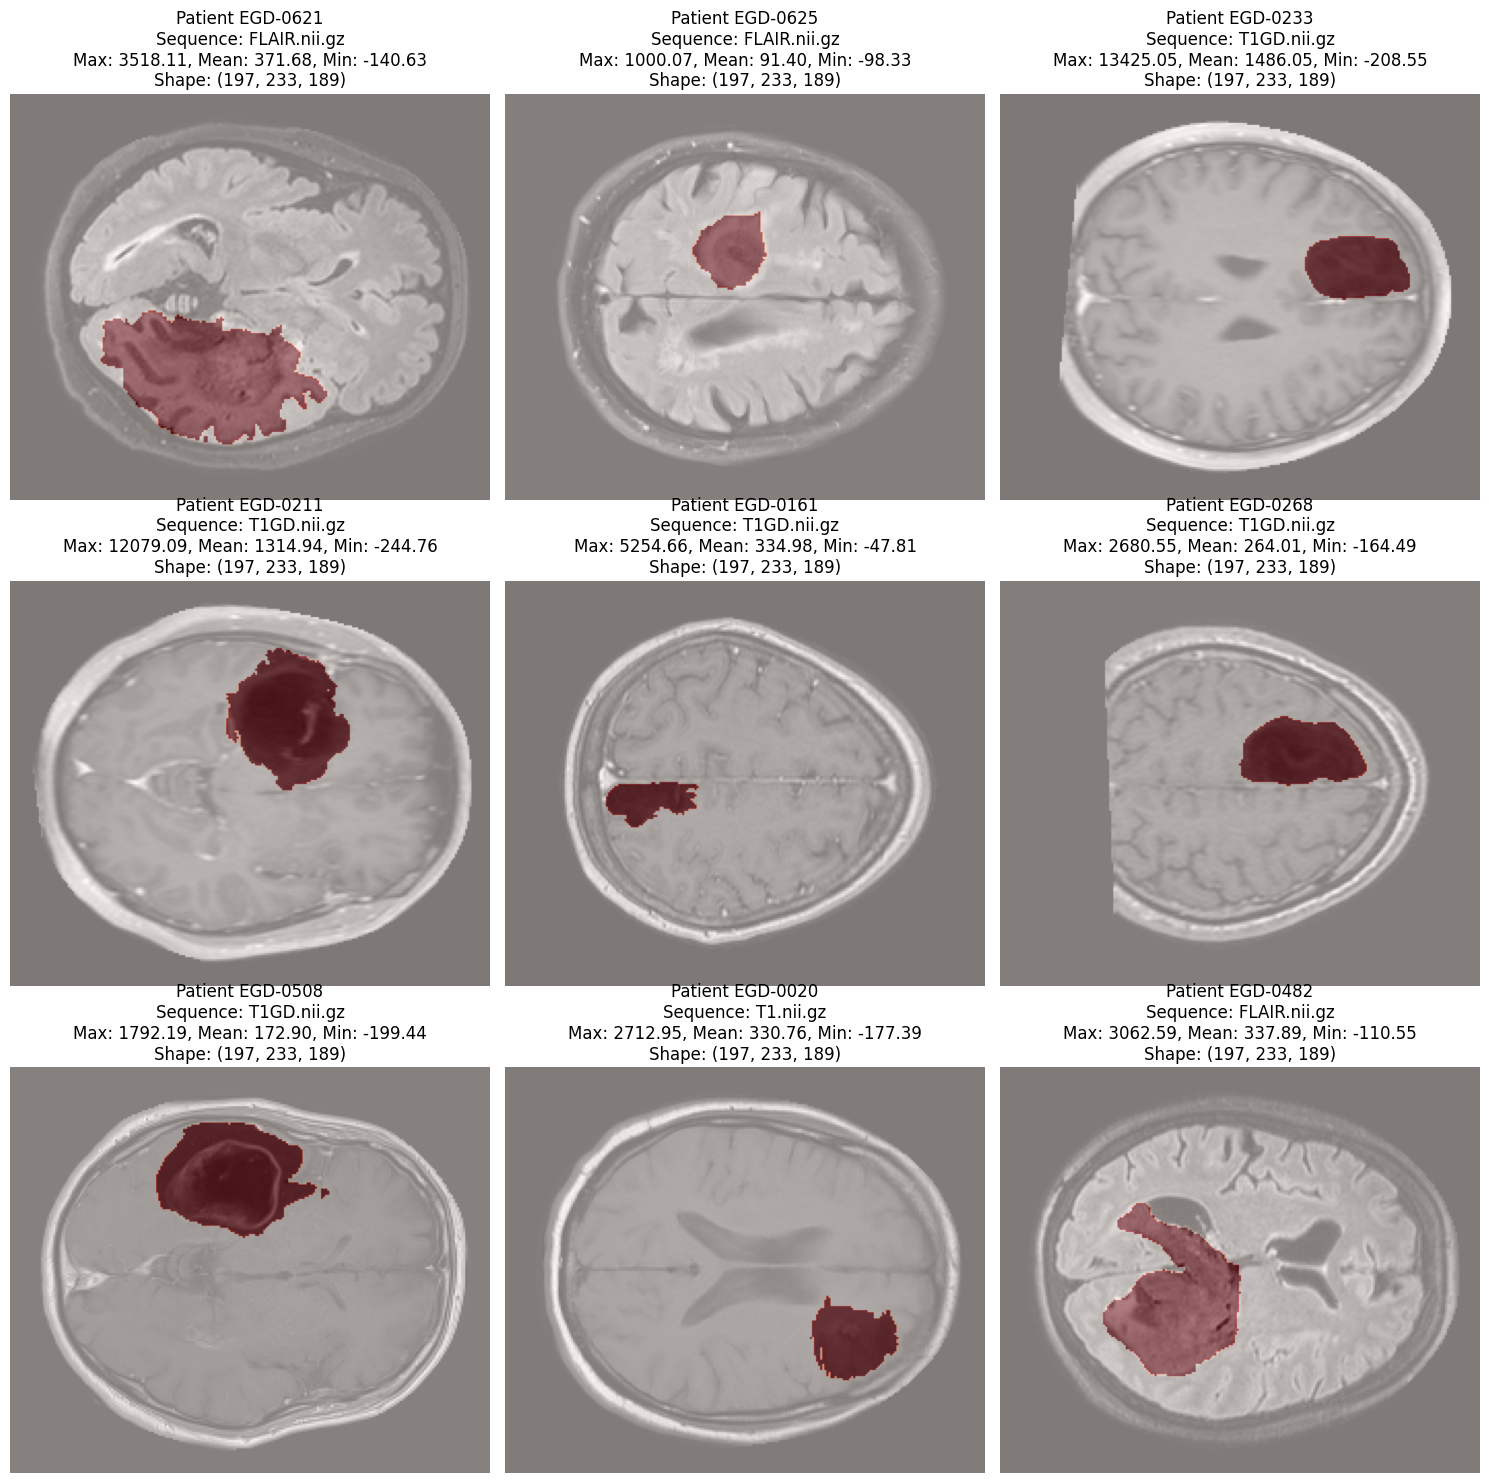

In [12]:
visualize_random_patients(all_patients)

## Remove erroneous patients

Patients with errors: 0221, 0118, 0160, 0369, 0133, 0502, 160, 0004, 0008, 0122


The issue is that while I exclusively want to use transversal MRI images, the dataset also contains images that were taken in other plains, which would distort the dataset. That's why I'm removing some of the patients. Unfortunately I cannot garantee that I will be able to catch them all.

In [11]:
erroneous_patients = ["0221", "0118", "0160", "0369", "0133", "0502", "0160", "0004", "0008", "0122", "0009", "0011", "0041", "0055", "0057", "0066", "0068", "0074", "0078", "0090", "0123", "0128", "0179", "0183", "0185", "0188", "0193", "0194", "0214", "0230", "0243", "0256", "0337", "0346", "0352", "0355", "0363", "0377", "0382", "0410", "0411", "0415", "0416", "0420", "0421", "0439", "0442", "0450", "0461", "0474", "0480", "0490", "0508", "0514", "0521", "0526", "0541", "0545", "0553", "0561", "0565", "0567", "0586", "0611", "0636", "0647", "0658", "0675", "0730", "0734", "0758", "0771"]

print(f"Number of all before removal of erroneous patients: {len(all_patients)}")
print(f"Number of erroneous patients: {len(erroneous_patients)}")

# remove erroneous patients
all_patients = [patient for patient in all_patients if patient.id.split("-")[1] not in erroneous_patients]

print(f"Number of all after removal of erroneous patients: {len(all_patients)}")

Number of all before removal of erroneous patients: 222
Number of erroneous patients: 72
Number of all after removal of erroneous patients: 151


I'll go through all the remaining files now, to see if all sequences seem to be properly recorded. Meaning all sequences have been recorded in the axial plane.

I'll ignore if some images don't have such a high resolution, only extrem cases get removed. MPRage images are also kept.

If there's a patient to remove, I'll add it to the list above.

In [14]:
def visualize_patients(patient):

    # Funktion zum Laden und Anzeigen eines NIfTI-Bildes
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    # 3x3 Grafik erstellen
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]

    for i, sequence in enumerate(sequences):
        ax = axes[i // 2, i % 2]
        
        # MRT Bild laden
        image = load_nifti_image(sequence)
        
        # Segmentierung laden
        segmentation = load_nifti_image(patient.tumor_segmentation)
        
        # Größte sichtbare Tumorschicht finden
        slice_index = np.argmax(np.sum(segmentation, axis=(0, 1)))
        
        # MRT Bild anzeigen
        ax.imshow(image[:, :, slice_index], cmap = 'gray')
        
        # Segmentierung farblich darüber legen
        ax.imshow(segmentation[:, :, slice_index], cmap='Reds', alpha=0.2)
        
        ax.axis('off')

        # Title
        max_value = np.max(image)
        mean_value = np.mean(image)
        min_value = np.min(image)

        title = (
            f'Patient {patient.id}\n'
            f'Sequence: {sequence.name}\n'
            f'Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}\n'
            f'Shape: {image.shape}'
        )

        ax.set_title(f'{title}')

    plt.tight_layout()
    plt.show()

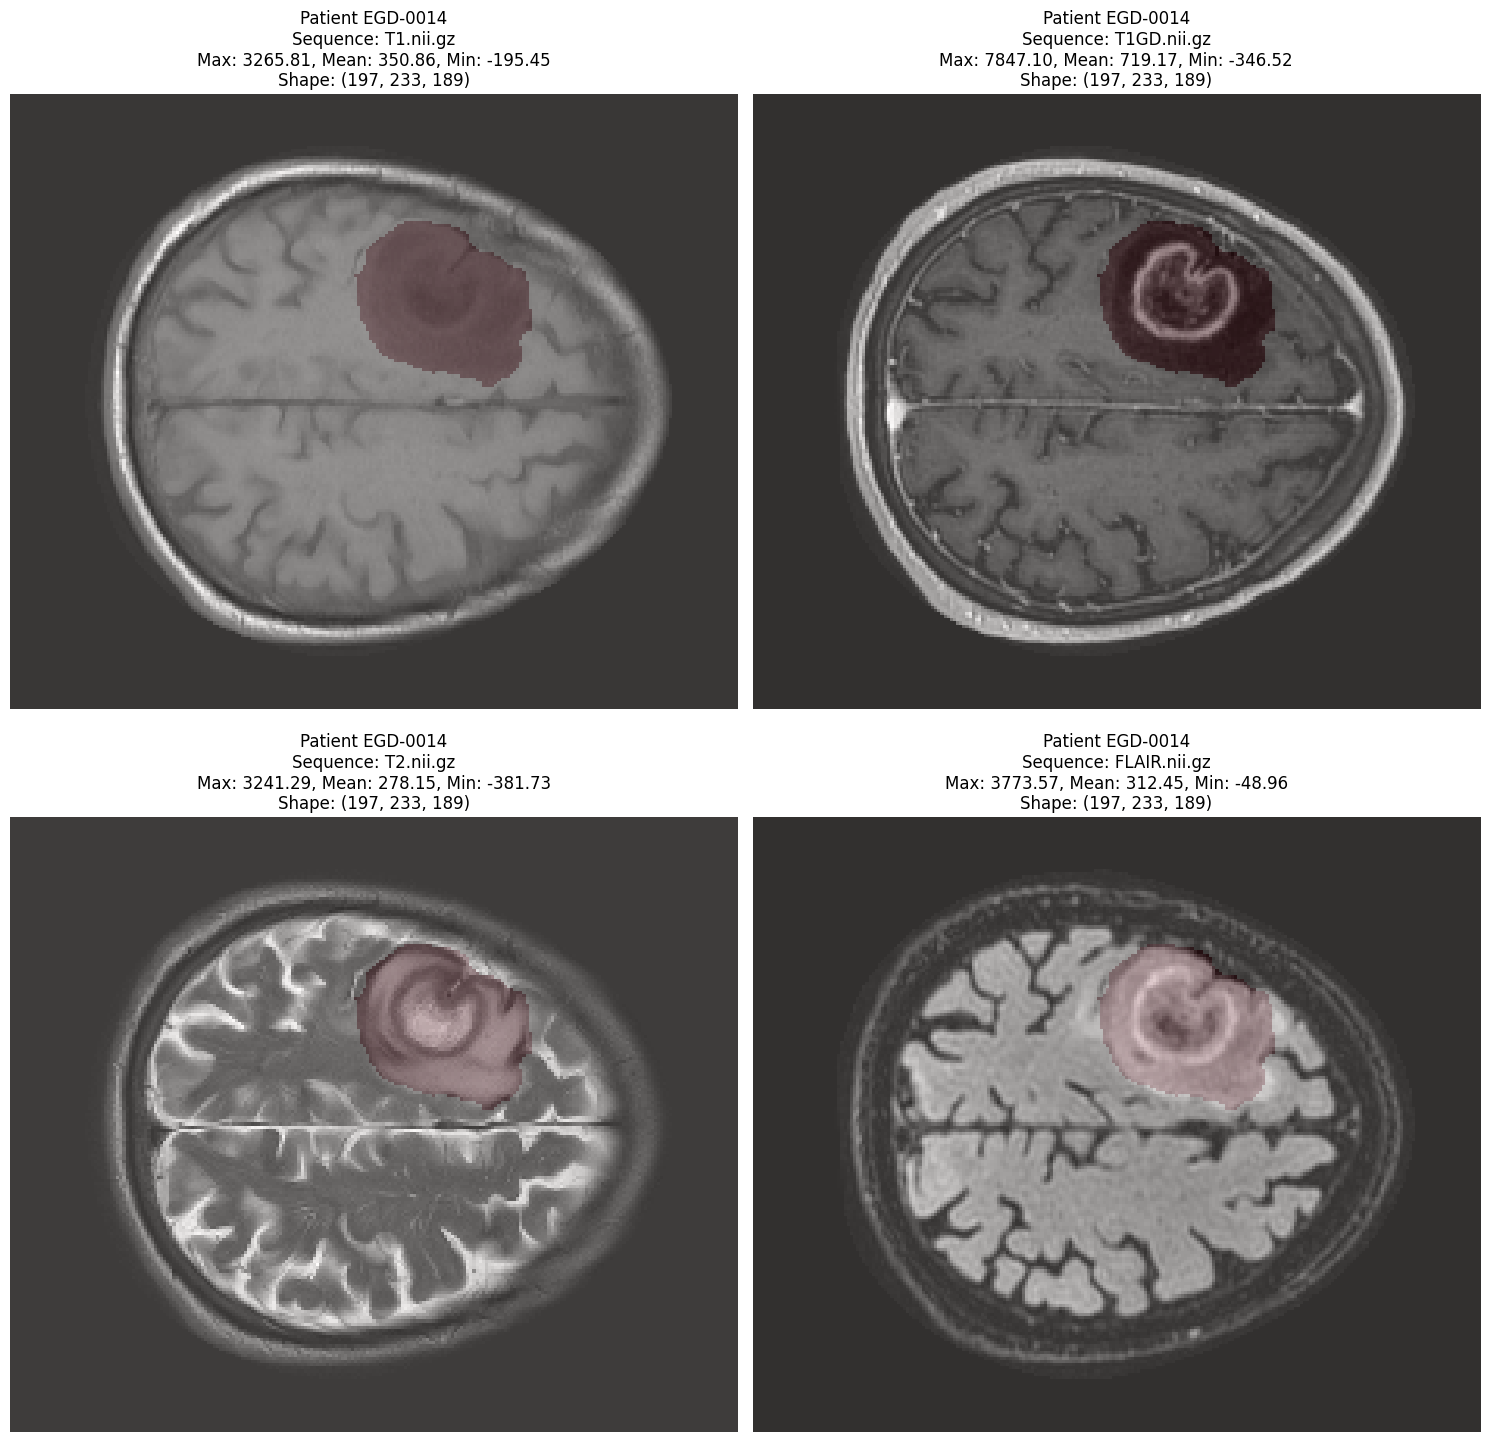

In [15]:
# Display 4 sequences and segmentation mask for a single patient
visualize_patients(all_patients[0])

After looking through all the possible patients, that can be used to classify the glioma grade, the amount of possible patients unfortunately shrunk quite a bit. The dataset seems to be quite heterogenous, espeically the T1 sequences are unfortunately very low quality. The FLAIR sequences are quite often MPRage images I think.

## Skullstripping the images
We'll use HD-Bet to skullsttrip the images to make them more uniform with the other datasets used.\
Here's the step by step plan:
- Iterate over each patient files
- Reorient the images
- Skullstrip the images
- Save them in a new directory

In [16]:
def reorient_Nifti_Image(path_to_image, path_to_output):
    image = nib.load(str(path_to_image))

    reorient = fsl.Reorient2Std()
    reorient.inputs.in_file = str(path_to_image)
    reorient.inputs.out_file = str(path_to_output)
    reorient.run()

In [17]:
def skull_strip_image(path_to_input_folder, path_to_output_folder):
    
    os.system(f"hd-bet -i {path_to_input_folder} -o {path_to_output_folder} -device cpu --disable_tta")

In [12]:
def get_skull_stripped_patients_paths():
    # check which images are already skull stripped

    path_to_skull_stripped_images = path_to_selected_egd_dataset_folder / "skull_stripped"
    skull_stripped_patient_paths = [path for path in path_to_skull_stripped_images.iterdir() if path.is_dir()]
    skull_stripped_patients = []

    # check if 4 images are in each folder and if they all end in .nii.gz
    for folder in skull_stripped_patient_paths:
        if not len(list(folder.iterdir())) == 4:
            print(f"Folder {folder} does not contain 4 images")
            print([file.name for file in folder.iterdir()])
        elif not all([file.name.endswith(".nii.gz") for file in folder.iterdir()]):
            print(f"Folder {folder} does not contain only .nii.gz files")
        else:
            #print(f"Folder {folder} is valid")
            skull_stripped_patients.append(folder)
    
    return skull_stripped_patients

In [13]:
skull_stripped_patients = get_skull_stripped_patients_paths()

print(f"Number of skull stripped patients: {len(skull_stripped_patients)}")

patients_to_skull_strip = [patient for patient in all_patients if patient.id not in [path.name for path in skull_stripped_patients]]
print(f"Number of patients to skull strip: {len(patients_to_skull_strip)}")

Number of skull stripped patients: 151
Number of patients to skull strip: 0


Actual Skull Stripping below - beware, the code takes forever because unfortunately I have to run it in CPU mode

In [26]:
# iterate over each patient

for patient in tqdm(patients_to_skull_strip):

    path_to_reoriented_output = ""

    # iterate over each sequence
    for sequence in [patient.t1, patient.t1c, patient.t2, patient.flair]:
        if sequence is not None:
            
            # create path to output
            path_to_reoriented_output = path_to_selected_egd_dataset_folder / "reoriented" / f"{patient.id}" / f"{sequence.stem}"
            path_to_reoriented_output.parent.mkdir(parents=True, exist_ok=True)

            #reorient the image
            reorient_Nifti_Image(
                path_to_image = sequence,
                path_to_output = path_to_reoriented_output
            )
    
    print(f"Reorientation for {patient.id} done")

    for sequence in [patient.t1, patient.t1c, patient.t2, patient.flair]:
        if sequence is not None:
            # create path to output
            path_to_skull_stripped_output = path_to_selected_egd_dataset_folder / "skull_stripped" / f"{patient.id}" / f"{sequence.stem}"
            path_to_skull_stripped_output.parent.mkdir(parents=True, exist_ok=True)

            path_to_reoriented_output = path_to_reoriented_output.parent / f"{sequence.stem}"

            print(path_to_skull_stripped_output)
            print(path_to_reoriented_output)
            # skull strip the image
            skull_strip_image(
                path_to_input_folder = str(path_to_reoriented_output),
                path_to_output_folder = str(path_to_skull_stripped_output) + ".nii.gz"
            )
    

  0%|          | 0/150 [00:00<?, ?it/s]

250324-14:38:23,723 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-14:38:24,820 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-14:38:25,399 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-14:38:25,974 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0020 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0020/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0020/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:51<00:00, 18.59s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0020/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0020/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:57<00:00, 19.60s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0020/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0020/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [02:02<00:00, 20.36s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0020/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0020/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:59<00:00, 19.97s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  1%|          | 1/150 [09:00<22:23:16, 540.92s/it]

250324-14:47:24,677 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-14:47:26,49 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-14:47:26,694 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-14:47:27,337 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0022 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0022/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0022/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:48<00:00, 18.12s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0022/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0022/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:33<00:00, 15.59s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0022/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0022/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:36<00:00, 16.09s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0022/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0022/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:50<00:00, 18.38s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  1%|▏         | 2/150 [16:56<20:39:11, 502.38s/it]

250324-14:55:20,52 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-14:55:21,339 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-14:55:21,939 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-14:55:22,554 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0024 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0024/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0024/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:49<00:00, 18.18s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0024/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0024/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:49<00:00, 18.22s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0024/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0024/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:42<00:00, 17.11s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0024/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0024/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:32<00:00, 15.48s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  2%|▏         | 3/150 [24:57<20:07:19, 492.79s/it]

250324-15:03:21,443 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:03:22,812 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:03:23,402 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:03:23,990 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0029 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0029/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0029/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:43<00:00, 17.25s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0029/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0029/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:40<00:00, 16.80s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0029/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0029/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:36<00:00, 16.00s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0029/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0029/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:55<00:00, 19.30s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  3%|▎         | 4/150 [33:01<19:50:29, 489.25s/it]

250324-15:11:25,258 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:11:26,674 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:11:27,281 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:11:27,918 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0033 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0033/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0033/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:38<00:00, 16.45s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0033/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0033/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:42<00:00, 17.12s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0033/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0033/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:54<00:00, 19.08s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0033/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0033/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [02:01<00:00, 20.24s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  3%|▎         | 5/150 [41:30<19:59:22, 496.30s/it]

250324-15:19:54,51 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:19:55,416 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:19:56,62 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:19:56,672 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0072 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0072/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0072/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P

100%|██████████| 6/6 [02:34<00:00, 25.72s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0072/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0072/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [02:17<00:00, 22.87s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0072/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0072/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [02:08<00:00, 21.36s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0072/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0072/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [02:13<00:00, 22.20s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  4%|▍         | 6/150 [51:54<21:35:29, 539.79s/it]

250324-15:30:18,264 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:30:19,626 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:30:20,206 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:30:20,794 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0073 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0073/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0073/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [02:24<00:00, 24.06s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0073/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0073/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [02:20<00:00, 23.34s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0073/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0073/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [02:19<00:00, 23.28s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0073/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0073/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:53<00:00, 18.90s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  5%|▍         | 7/150 [1:02:03<22:20:39, 562.52s/it]

250324-15:40:27,573 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:40:28,898 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:40:29,510 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:40:30,202 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0075 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0075/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0075/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:58<00:00, 19.76s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0075/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0075/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:47<00:00, 17.87s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0075/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0075/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [02:48<00:00, 28.14s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0075/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0075/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [02:58<00:00, 29.67s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  5%|▌         | 8/150 [1:12:49<23:13:46, 588.92s/it]

250324-15:51:13,41 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:51:14,609 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:51:15,304 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-15:51:15,961 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0080 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0080/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0080/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [02:49<00:00, 28.29s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0080/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0080/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [02:39<00:00, 26.59s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0080/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0080/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [02:53<00:00, 28.95s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0080/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0080/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [02:04<00:00, 20.80s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  6%|▌         | 9/150 [1:24:32<24:27:58, 624.67s/it]

250324-16:02:56,313 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:02:57,779 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:02:58,359 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:02:58,928 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0085 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0085/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0085/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [02:04<00:00, 20.83s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0085/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0085/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:37<00:00, 16.33s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0085/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0085/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:53<00:00, 18.96s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0085/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0085/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:47<00:00, 17.86s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  7%|▋         | 10/150 [1:33:02<22:54:53, 589.24s/it]

250324-16:11:26,212 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:11:27,573 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:11:28,146 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:11:28,735 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0086 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0086/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0086/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:22<00:00, 13.80s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0086/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0086/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:24<00:00, 14.02s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0086/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0086/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:25<00:00, 14.26s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0086/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0086/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:19<00:00, 13.30s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  7%|▋         | 11/150 [1:39:32<20:23:54, 528.31s/it]

250324-16:17:56,351 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:17:57,627 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:17:58,195 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:17:58,764 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0099 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0099/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0099/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:28<00:00, 14.76s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0099/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0099/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:21<00:00, 13.51s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0099/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0099/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:24<00:00, 14.01s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0099/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0099/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:23<00:00, 13.84s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  8%|▊         | 12/150 [1:46:08<18:42:35, 488.08s/it]

250324-16:24:32,441 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:24:33,732 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:24:34,317 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:24:34,889 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0101 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0101/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0101/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:22<00:00, 13.76s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0101/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0101/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:22<00:00, 13.83s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0101/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0101/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.59s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0101/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0101/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:31<00:00, 15.21s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  9%|▊         | 13/150 [1:52:50<17:34:58, 462.03s/it]

250324-16:31:14,522 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:31:15,927 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:31:16,700 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:31:17,374 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0106 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0106/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0106/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [02:46<00:00, 27.76s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0106/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0106/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [02:28<00:00, 24.74s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0106/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0106/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [02:10<00:00, 21.77s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0106/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0106/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [02:27<00:00, 24.54s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


  9%|▉         | 14/150 [2:03:57<19:47:41, 523.98s/it]

250324-16:42:21,672 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:42:23,189 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:42:23,808 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:42:24,428 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0107 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0107/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0107/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [02:17<00:00, 22.93s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0107/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0107/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [02:04<00:00, 20.80s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0107/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0107/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [02:17<00:00, 22.88s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0107/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0107/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [02:08<00:00, 21.46s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 10%|█         | 15/150 [2:13:59<20:31:48, 547.47s/it]

250324-16:52:23,577 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:52:25,90 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:52:25,806 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-16:52:26,512 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0115 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0115/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0115/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [02:08<00:00, 21.40s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0115/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0115/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [02:06<00:00, 21.10s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0115/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0115/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:37<00:00, 16.33s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0115/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0115/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:35<00:00, 15.98s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 11%|█         | 16/150 [2:22:37<20:02:49, 538.58s/it]

250324-17:01:01,513 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:01:02,868 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:01:03,459 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:01:04,43 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0137 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0137/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0137/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:37<00:00, 16.25s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0137/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0137/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:41<00:00, 16.89s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0137/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0137/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:31<00:00, 15.30s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0137/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0137/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:32<00:00, 15.34s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 11%|█▏        | 17/150 [2:30:02<18:51:15, 510.34s/it]

250324-17:08:26,161 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:08:27,495 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:08:28,84 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:08:28,674 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0143 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0143/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0143/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:42<00:00, 17.00s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0143/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0143/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:30<00:00, 15.12s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0143/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0143/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:30<00:00, 15.14s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0143/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0143/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:35<00:00, 15.88s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 12%|█▏        | 18/150 [2:37:24<17:57:52, 489.94s/it]

250324-17:15:48,614 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:15:50,20 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:15:50,630 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:15:51,220 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0144 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0144/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0144/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:39<00:00, 16.57s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0144/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0144/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:38<00:00, 16.50s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0144/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0144/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:31<00:00, 15.32s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0144/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0144/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.47s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 13%|█▎        | 19/150 [2:44:45<17:17:05, 475.00s/it]

250324-17:23:08,816 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:23:10,162 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:23:10,752 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:23:11,344 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0145 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0145/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0145/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:28<00:00, 14.69s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0145/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0145/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:37<00:00, 16.28s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0145/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0145/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:43<00:00, 17.21s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0145/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0145/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:34<00:00, 15.81s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 13%|█▎        | 20/150 [2:52:13<16:52:05, 467.12s/it]

250324-17:30:37,577 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:30:39,698 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:30:40,327 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:30:40,953 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0146 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0146/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0146/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:29<00:00, 14.98s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0146/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0146/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:47<00:00, 17.99s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0146/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0146/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:32<00:00, 15.36s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0146/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0146/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:40<00:00, 16.77s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 14%|█▍        | 21/150 [2:59:51<16:38:04, 464.22s/it]

250324-17:38:15,43 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:38:16,845 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:38:17,473 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:38:18,62 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0161 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0161/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0161/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P

100%|██████████| 6/6 [01:39<00:00, 16.64s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0161/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0161/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:34<00:00, 15.76s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0161/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0161/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:29<00:00, 14.95s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0161/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0161/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:34<00:00, 15.68s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 15%|█▍        | 22/150 [3:07:16<16:18:06, 458.49s/it]

250324-17:45:40,159 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:45:41,607 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:45:42,207 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:45:42,791 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0162 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0162/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0162/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:50<00:00, 18.35s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0162/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0162/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:33<00:00, 15.57s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0162/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0162/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:29<00:00, 14.83s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0162/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0162/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:37<00:00, 16.31s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 15%|█▌        | 23/150 [3:14:50<16:07:25, 457.05s/it]

250324-17:53:13,851 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:53:15,184 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:53:15,785 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-17:53:16,381 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0165 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0165/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0165/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:27<00:00, 14.52s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0165/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0165/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:39<00:00, 16.53s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0165/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0165/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:46<00:00, 17.81s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0165/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0165/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:33<00:00, 15.53s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 16%|█▌        | 24/150 [3:22:19<15:54:53, 454.71s/it]

250324-18:00:43,115 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:00:44,444 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:00:45,49 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:00:45,640 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0176 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0176/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0176/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:30<00:00, 15.01s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0176/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0176/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.65s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0176/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0176/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:28<00:00, 14.67s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0176/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0176/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:33<00:00, 15.55s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 17%|█▋        | 25/150 [3:29:20<15:26:09, 444.56s/it]

250324-18:07:43,973 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:07:45,311 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:07:45,893 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:07:46,477 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0177 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0177/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0177/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:32<00:00, 15.42s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0177/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0177/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:21<00:00, 13.64s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0177/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0177/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:24<00:00, 14.05s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0177/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0177/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:21<00:00, 13.58s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 17%|█▋        | 26/150 [3:35:58<14:50:04, 430.68s/it]

250324-18:14:22,267 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:14:23,557 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:14:24,128 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:14:24,704 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0186 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0186/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0186/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:32<00:00, 15.49s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0186/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0186/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:31<00:00, 15.28s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0186/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0186/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:47<00:00, 17.87s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0186/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0186/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:31<00:00, 15.19s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 18%|█▊        | 27/150 [3:43:24<14:52:33, 435.39s/it]

250324-18:21:48,660 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:21:50,26 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:21:50,627 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:21:51,220 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0187 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0187/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0187/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:32<00:00, 15.40s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0187/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0187/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:34<00:00, 15.68s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0187/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0187/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:31<00:00, 15.18s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0187/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0187/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.43s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 19%|█▊        | 28/150 [3:50:34<14:41:35, 433.57s/it]

250324-18:28:57,983 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:28:59,282 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:28:59,868 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:29:00,454 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0192 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0192/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0192/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:26<00:00, 14.42s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0192/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0192/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:31<00:00, 15.21s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0192/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0192/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:48<00:00, 18.13s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0192/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0192/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:36<00:00, 16.12s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 19%|█▉        | 29/150 [3:57:58<14:40:59, 436.85s/it]

250324-18:36:22,494 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:36:24,613 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:36:25,183 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:36:25,760 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0196 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0196/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0196/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:33<00:00, 15.58s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0196/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0196/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:37<00:00, 16.30s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0196/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0196/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:35<00:00, 15.97s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0196/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0196/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:39<00:00, 16.56s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 20%|██        | 30/150 [4:05:27<14:40:41, 440.34s/it]

250324-18:43:50,982 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:43:52,302 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:43:52,890 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:43:53,466 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0197 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0197/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0197/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:45<00:00, 17.59s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0197/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0197/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:34<00:00, 15.73s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0197/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0197/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:23<00:00, 14.00s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0197/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0197/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.52s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 21%|██        | 31/150 [4:12:41<14:29:58, 438.64s/it]

250324-18:51:05,663 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:51:06,980 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:51:07,563 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:51:08,144 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0198 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0198/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0198/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:30<00:00, 15.16s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0198/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0198/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:33<00:00, 15.58s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0198/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0198/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:43<00:00, 17.20s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0198/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0198/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:36<00:00, 16.05s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 21%|██▏       | 32/150 [4:20:06<14:26:17, 440.49s/it]

250324-18:58:30,478 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:58:31,843 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:58:32,419 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-18:58:32,993 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0199 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0199/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0199/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:30<00:00, 15.14s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0199/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0199/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:26<00:00, 14.35s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0199/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0199/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:43<00:00, 17.33s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0199/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0199/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:32<00:00, 15.42s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 22%|██▏       | 33/150 [4:27:22<14:16:13, 439.09s/it]

250324-19:05:46,283 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:05:47,588 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:05:48,169 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:05:48,759 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0202 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0202/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0202/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:37<00:00, 16.20s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0202/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0202/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:30<00:00, 15.07s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0202/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0202/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:34<00:00, 15.72s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0202/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0202/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.52s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 23%|██▎       | 34/150 [4:34:33<14:04:20, 436.73s/it]

250324-19:12:57,497 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:12:58,770 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:12:59,339 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:12:59,908 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0203 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0203/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0203/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:31<00:00, 15.32s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0203/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0203/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.26s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0203/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0203/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:26<00:00, 14.48s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0203/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0203/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.48s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 23%|██▎       | 35/150 [4:41:25<13:42:30, 429.13s/it]

250324-19:19:48,913 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:19:50,208 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:19:50,776 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:19:51,353 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0208 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0208/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0208/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:28<00:00, 14.78s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0208/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0208/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:32<00:00, 15.47s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0208/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0208/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:32<00:00, 15.34s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0208/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0208/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.56s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 24%|██▍       | 36/150 [4:48:25<13:30:11, 426.42s/it]

250324-19:26:48,992 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:26:50,285 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:26:50,870 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:26:51,432 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0211 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0211/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0211/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:32<00:00, 15.50s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0211/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0211/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:36<00:00, 16.14s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0211/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0211/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:33<00:00, 15.59s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0211/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0211/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:31<00:00, 15.30s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 25%|██▍       | 37/150 [4:55:42<13:29:06, 429.62s/it]

250324-19:34:06,78 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:34:07,429 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:34:08,42 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:34:08,667 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0217 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0217/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0217/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P

100%|██████████| 6/6 [01:27<00:00, 14.60s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0217/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0217/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:28<00:00, 14.73s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0217/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0217/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:30<00:00, 15.10s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0217/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0217/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:32<00:00, 15.44s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 25%|██▌       | 38/150 [5:02:41<13:16:13, 426.55s/it]

250324-19:41:05,470 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:41:06,739 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:41:07,317 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:41:07,886 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0226 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0226/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0226/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:34<00:00, 15.70s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0226/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0226/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:28<00:00, 14.78s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0226/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0226/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:41<00:00, 16.86s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0226/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0226/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:34<00:00, 15.70s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 26%|██▌       | 39/150 [5:10:00<13:15:45, 430.14s/it]

250324-19:48:23,980 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:48:25,260 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:48:25,829 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:48:26,391 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0228 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0228/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0228/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:30<00:00, 15.01s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0228/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0228/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:28<00:00, 14.78s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0228/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0228/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:41<00:00, 16.90s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0228/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0228/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:25<00:00, 14.24s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 27%|██▋       | 40/150 [5:17:06<13:06:21, 428.92s/it]

250324-19:55:30,54 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:55:31,347 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:55:31,916 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-19:55:32,486 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0229 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0229/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0229/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:29<00:00, 15.00s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0229/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0229/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.57s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0229/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0229/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:37<00:00, 16.23s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0229/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0229/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.64s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 27%|██▋       | 41/150 [5:24:06<12:54:42, 426.44s/it]

250324-20:02:30,719 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:02:32,4 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:02:32,577 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:02:33,153 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0233 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0233/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0233/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P

100%|██████████| 6/6 [01:31<00:00, 15.20s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0233/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0233/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:34<00:00, 15.76s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0233/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0233/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:28<00:00, 14.73s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0233/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0233/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:30<00:00, 15.15s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 28%|██▊       | 42/150 [5:31:11<12:46:34, 425.87s/it]

250324-20:09:35,265 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:09:36,577 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:09:37,141 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:09:37,715 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0234 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0234/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0234/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:27<00:00, 14.53s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0234/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0234/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.50s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0234/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0234/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:26<00:00, 14.35s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0234/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0234/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.59s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 29%|██▊       | 43/150 [5:37:58<12:29:29, 420.27s/it]

250324-20:16:22,479 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:16:23,751 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:16:24,336 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:16:24,914 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0236 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0236/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0236/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:34<00:00, 15.71s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0236/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0236/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:32<00:00, 15.48s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0236/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0236/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:30<00:00, 15.01s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0236/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0236/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:38<00:00, 16.34s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 29%|██▉       | 44/150 [5:45:14<12:30:30, 424.82s/it]

250324-20:23:37,895 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:23:39,207 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:23:39,769 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:23:40,326 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0240 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0240/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0240/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:32<00:00, 15.47s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0240/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0240/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:38<00:00, 16.39s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0240/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0240/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.64s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0240/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0240/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:33<00:00, 15.61s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 30%|███       | 45/150 [5:52:26<12:27:25, 427.10s/it]

250324-20:30:50,308 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:30:51,603 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:30:52,161 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:30:52,722 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0241 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0241/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0241/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:36<00:00, 16.03s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0241/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0241/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:34<00:00, 15.75s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0241/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0241/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:33<00:00, 15.57s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0241/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0241/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:23<00:00, 13.92s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 31%|███       | 46/150 [5:59:36<12:21:51, 428.00s/it]

250324-20:38:00,405 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:38:01,652 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:38:02,213 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:38:02,780 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0244 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0244/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0244/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:42<00:00, 17.01s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0244/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0244/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:30<00:00, 15.13s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0244/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0244/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:31<00:00, 15.19s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0244/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0244/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.39s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 31%|███▏      | 47/150 [6:06:45<12:15:22, 428.37s/it]

250324-20:45:09,642 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:45:10,906 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:45:11,472 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:45:12,42 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0247 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0247/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0247/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:26<00:00, 14.47s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0247/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0247/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:29<00:00, 14.87s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0247/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0247/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:29<00:00, 14.98s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0247/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0247/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.37s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 32%|███▏      | 48/150 [6:13:37<11:59:29, 423.23s/it]

250324-20:52:00,884 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:52:02,173 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:52:02,736 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:52:03,302 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0253 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0253/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0253/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:38<00:00, 16.48s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0253/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0253/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:34<00:00, 15.75s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0253/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0253/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:32<00:00, 15.41s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0253/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0253/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.52s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 33%|███▎      | 49/150 [6:20:49<11:57:08, 426.03s/it]

250324-20:59:13,445 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:59:14,647 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:59:15,210 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-20:59:15,771 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0268 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0268/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0268/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:28<00:00, 14.76s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0268/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0268/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:35<00:00, 15.92s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0268/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0268/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:21<00:00, 13.58s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0268/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0268/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:33<00:00, 15.50s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 33%|███▎      | 50/150 [6:27:46<11:45:35, 423.35s/it]

250324-21:06:10,554 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:06:11,806 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:06:12,388 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:06:12,959 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0280 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0280/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0280/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:23<00:00, 13.90s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0280/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0280/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:26<00:00, 14.43s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0280/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0280/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:20<00:00, 13.47s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0280/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0280/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:24<00:00, 14.13s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 34%|███▍      | 51/150 [6:34:20<11:24:00, 414.55s/it]

250324-21:12:44,562 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:12:45,854 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:12:46,416 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:12:46,983 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0286 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0286/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0286/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:24<00:00, 14.06s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0286/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0286/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:26<00:00, 14.45s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0286/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0286/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:23<00:00, 13.87s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0286/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0286/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:24<00:00, 14.16s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 35%|███▍      | 52/150 [6:40:59<11:09:16, 409.76s/it]

250324-21:19:23,154 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:19:24,429 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:19:24,992 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:19:25,556 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0297 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0297/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0297/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:28<00:00, 14.80s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0297/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0297/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:32<00:00, 15.39s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0297/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0297/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:30<00:00, 15.08s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0297/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0297/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:33<00:00, 15.65s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 35%|███▌      | 53/150 [6:48:05<11:10:17, 414.62s/it]

250324-21:26:29,101 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:26:30,385 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:26:30,946 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:26:31,509 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0301 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0301/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0301/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:28<00:00, 14.72s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0301/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0301/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:35<00:00, 15.90s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0301/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0301/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:31<00:00, 15.31s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0301/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0301/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:32<00:00, 15.48s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 36%|███▌      | 54/150 [6:55:12<11:09:37, 418.51s/it]

250324-21:33:36,695 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:33:37,978 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:33:38,538 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:33:39,103 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0306 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0306/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0306/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:26<00:00, 14.36s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0306/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0306/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:28<00:00, 14.81s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0306/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0306/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:29<00:00, 14.98s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0306/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0306/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:30<00:00, 15.03s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 37%|███▋      | 55/150 [7:02:08<11:01:11, 417.59s/it]

250324-21:40:32,132 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:40:33,399 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:40:33,992 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:40:34,581 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0309 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0309/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0309/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:31<00:00, 15.18s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0309/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0309/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:30<00:00, 15.16s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0309/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0309/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:28<00:00, 14.80s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0309/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0309/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.59s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 37%|███▋      | 56/150 [7:09:05<10:54:09, 417.55s/it]

250324-21:47:29,582 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:47:30,855 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:47:31,415 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:47:31,980 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0312 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0312/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0312/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:28<00:00, 14.77s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0312/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0312/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:22<00:00, 13.76s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0312/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0312/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:35<00:00, 15.97s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0312/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0312/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.49s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 38%|███▊      | 57/150 [7:15:59<10:45:13, 416.27s/it]

250324-21:54:22,884 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:54:24,160 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:54:24,728 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-21:54:25,295 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0319 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0319/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0319/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:33<00:00, 15.51s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0319/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0319/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:28<00:00, 14.80s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0319/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0319/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.63s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0319/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0319/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.59s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 39%|███▊      | 58/150 [7:22:55<10:38:18, 416.28s/it]

250324-22:01:19,188 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:01:20,476 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:01:21,48 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:01:21,622 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0321 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0321/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0321/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:24<00:00, 14.12s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0321/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0321/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:23<00:00, 13.95s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0321/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0321/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.55s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0321/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0321/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.37s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 39%|███▉      | 59/150 [7:29:37<10:24:56, 412.05s/it]

250324-22:08:01,371 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:08:02,664 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:08:03,226 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:08:03,797 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0330 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0330/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0330/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:27<00:00, 14.64s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0330/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0330/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:26<00:00, 14.43s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0330/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0330/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:30<00:00, 15.05s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0330/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0330/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:23<00:00, 13.95s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 40%|████      | 60/150 [7:36:26<10:16:34, 411.05s/it]

250324-22:14:50,79 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:14:51,367 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:14:51,938 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:14:52,511 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0332 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0332/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0332/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:32<00:00, 15.37s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0332/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0332/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:26<00:00, 14.36s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0332/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0332/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:38<00:00, 16.36s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0332/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0332/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.46s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 41%|████      | 61/150 [7:43:28<10:14:42, 414.41s/it]

250324-22:21:52,318 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:21:53,650 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:21:54,220 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:21:54,788 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0338 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0338/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0338/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:27<00:00, 14.60s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0338/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0338/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:32<00:00, 15.46s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0338/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0338/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:33<00:00, 15.62s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0338/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0338/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:36<00:00, 16.09s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 41%|████▏     | 62/150 [7:50:40<10:15:18, 419.52s/it]

250324-22:29:03,786 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:29:05,90 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:29:05,681 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:29:06,276 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0340 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0340/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0340/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:44<00:00, 17.45s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0340/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0340/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:39<00:00, 16.50s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0340/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0340/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:41<00:00, 16.90s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0340/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0340/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:35<00:00, 15.96s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 42%|████▏     | 63/150 [7:58:22<10:26:58, 432.40s/it]

250324-22:36:46,221 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:36:47,483 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:36:48,82 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:36:48,677 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0344 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0344/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0344/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:27<00:00, 14.62s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0344/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0344/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:31<00:00, 15.28s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0344/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0344/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:28<00:00, 14.73s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0344/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0344/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:29<00:00, 14.86s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 43%|████▎     | 64/150 [8:05:21<10:13:52, 428.29s/it]

250324-22:43:44,918 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:43:46,256 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:43:46,847 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:43:47,445 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0349 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0349/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0349/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:33<00:00, 15.51s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0349/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0349/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:39<00:00, 16.58s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0349/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0349/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:40<00:00, 16.68s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0349/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0349/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:34<00:00, 15.67s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 43%|████▎     | 65/150 [8:12:48<10:14:42, 433.92s/it]

250324-22:51:11,963 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:51:13,269 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:51:13,878 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:51:14,480 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0351 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0351/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0351/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:32<00:00, 15.43s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0351/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0351/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:36<00:00, 16.04s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0351/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0351/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:30<00:00, 15.02s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0351/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0351/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:34<00:00, 15.77s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 44%|████▍     | 66/150 [8:20:02<10:07:33, 433.97s/it]

250324-22:58:26,46 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:58:27,366 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:58:27,960 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-22:58:28,555 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0356 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0356/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0356/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:28<00:00, 14.83s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0356/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0356/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:35<00:00, 15.94s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0356/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0356/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:31<00:00, 15.29s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0356/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0356/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:34<00:00, 15.70s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 45%|████▍     | 67/150 [8:27:13<9:59:17, 433.23s/it] 

250324-23:05:37,551 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:05:38,814 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:05:39,428 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:05:40,19 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0357 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0357/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0357/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:29<00:00, 14.92s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0357/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0357/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:33<00:00, 15.60s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0357/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0357/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:34<00:00, 15.75s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0357/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0357/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:38<00:00, 16.46s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 45%|████▌     | 68/150 [8:34:30<9:53:17, 434.12s/it]

250324-23:12:53,743 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:12:54,990 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:12:55,573 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:12:56,166 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0368 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0368/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0368/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:32<00:00, 15.47s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0368/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0368/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:29<00:00, 14.94s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0368/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0368/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:31<00:00, 15.28s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0368/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0368/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:29<00:00, 14.92s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 46%|████▌     | 69/150 [8:41:34<9:42:14, 431.30s/it]

250324-23:19:58,451 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:19:59,752 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:20:00,340 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:20:00,915 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0378 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0378/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0378/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:35<00:00, 15.86s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0378/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0378/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:28<00:00, 14.81s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0378/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0378/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:22<00:00, 13.82s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0378/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0378/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:29<00:00, 14.85s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 47%|████▋     | 70/150 [8:48:31<9:29:04, 426.81s/it]

250324-23:26:54,802 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:26:56,105 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:26:56,666 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:26:57,237 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0385 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0385/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0385/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:32<00:00, 15.43s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0385/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0385/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:23<00:00, 13.97s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0385/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0385/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:24<00:00, 14.09s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0385/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0385/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:39<00:00, 16.61s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 47%|████▋     | 71/150 [8:55:30<9:19:07, 424.65s/it]

250324-23:33:54,394 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:33:55,706 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:33:56,282 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:33:56,856 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0387 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0387/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0387/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:29<00:00, 14.92s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0387/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0387/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:20<00:00, 13.42s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0387/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0387/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:32<00:00, 15.42s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0387/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0387/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:24<00:00, 14.06s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 48%|████▊     | 72/150 [9:02:14<9:04:02, 418.49s/it]

250324-23:40:38,527 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:40:39,818 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:40:40,394 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:40:40,988 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0389 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0389/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0389/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:36<00:00, 16.08s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0389/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0389/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:30<00:00, 15.01s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0389/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0389/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.53s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0389/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0389/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:28<00:00, 14.69s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 49%|████▊     | 73/150 [9:09:14<8:57:39, 418.96s/it]

250324-23:47:38,581 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:47:39,864 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:47:40,424 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:47:40,990 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0390 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0390/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0390/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:27<00:00, 14.58s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0390/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0390/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:23<00:00, 13.91s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0390/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0390/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:26<00:00, 14.35s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0390/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0390/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:21<00:00, 13.63s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 49%|████▉     | 74/150 [9:15:51<8:42:03, 412.15s/it]

250324-23:54:14,842 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:54:16,106 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:54:16,671 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250324-23:54:17,237 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0394 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0394/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0394/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:23<00:00, 13.90s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0394/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0394/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.28s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0394/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0394/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:21<00:00, 13.65s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0394/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0394/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:32<00:00, 15.36s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 50%|█████     | 75/150 [9:22:32<8:31:06, 408.88s/it]

250325-00:00:56,97 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:00:57,322 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:00:57,890 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:00:58,460 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0400 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0400/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0400/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:23<00:00, 13.98s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0400/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0400/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.26s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0400/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0400/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:21<00:00, 13.53s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0400/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0400/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:20<00:00, 13.40s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 51%|█████     | 76/150 [9:29:00<8:16:26, 402.52s/it]

250325-00:07:23,775 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:07:25,15 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:07:25,583 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:07:26,153 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0401 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0401/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0401/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:23<00:00, 13.98s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0401/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0401/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:24<00:00, 14.05s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0401/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0401/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.51s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0401/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0401/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:25<00:00, 14.24s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 51%|█████▏    | 77/150 [9:35:37<8:07:49, 400.95s/it]

250325-00:14:01,59 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:14:02,309 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:14:02,887 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:14:03,450 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0403 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0403/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0403/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:24<00:00, 14.00s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0403/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0403/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:24<00:00, 14.09s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0403/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0403/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:26<00:00, 14.36s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0403/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0403/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.34s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 52%|█████▏    | 78/150 [9:42:15<8:00:13, 400.19s/it]

250325-00:20:39,466 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:20:40,735 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:20:41,289 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:20:41,869 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0413 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0413/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0413/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:24<00:00, 14.03s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0413/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0413/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:31<00:00, 15.30s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0413/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0413/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:24<00:00, 14.04s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0413/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0413/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:24<00:00, 14.11s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 53%|█████▎    | 79/150 [9:48:58<7:54:33, 401.04s/it]

250325-00:27:22,500 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:27:23,792 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:27:24,359 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:27:24,926 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0417 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0417/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0417/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:28<00:00, 14.79s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0417/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0417/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.59s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0417/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0417/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:23<00:00, 13.94s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0417/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0417/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:29<00:00, 14.88s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 53%|█████▎    | 80/150 [9:55:46<7:50:14, 403.07s/it]

250325-00:34:10,298 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:34:11,581 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:34:12,143 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:34:12,715 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0426 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0426/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0426/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:24<00:00, 14.03s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0426/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0426/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:24<00:00, 14.12s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0426/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0426/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.57s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0426/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0426/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:28<00:00, 14.71s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 54%|█████▍    | 81/150 [10:02:30<7:43:42, 403.22s/it]

250325-00:40:53,879 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:40:55,144 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:40:55,729 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:40:56,292 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0432 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0432/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0432/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:34<00:00, 15.77s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0432/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0432/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:35<00:00, 15.94s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0432/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0432/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:28<00:00, 14.68s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0432/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0432/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:25<00:00, 14.30s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 55%|█████▍    | 82/150 [10:09:34<7:44:13, 409.62s/it]

250325-00:47:58,424 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:47:59,720 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:48:00,290 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:48:00,859 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0434 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0434/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0434/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:33<00:00, 15.62s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0434/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0434/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:26<00:00, 14.46s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0434/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0434/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:32<00:00, 15.40s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0434/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0434/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:24<00:00, 14.02s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 55%|█████▌    | 83/150 [10:16:31<7:39:58, 411.92s/it]

250325-00:54:55,697 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:54:56,976 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:54:57,544 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-00:54:58,117 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0438 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0438/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0438/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:33<00:00, 15.51s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0438/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0438/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:39<00:00, 16.62s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0438/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0438/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:35<00:00, 15.95s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0438/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0438/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:30<00:00, 15.02s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 56%|█████▌    | 84/150 [10:23:50<7:41:56, 419.95s/it]

250325-01:02:14,387 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:02:15,678 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:02:16,238 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:02:16,803 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0453 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0453/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0453/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:29<00:00, 14.90s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0453/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0453/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:28<00:00, 14.76s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0453/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0453/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.63s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0453/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0453/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:25<00:00, 14.20s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 57%|█████▋    | 85/150 [10:30:41<7:32:03, 417.29s/it]

250325-01:09:05,472 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:09:06,783 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:09:07,351 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:09:07,922 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0466 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0466/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0466/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:38<00:00, 16.45s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0466/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0466/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:36<00:00, 16.15s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0466/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0466/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:39<00:00, 16.61s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0466/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0466/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:39<00:00, 16.51s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 57%|█████▋    | 86/150 [10:38:15<7:36:40, 428.14s/it]

250325-01:16:38,924 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:16:40,219 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:16:40,786 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:16:41,357 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0472 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0472/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0472/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:37<00:00, 16.24s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0472/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0472/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.55s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0472/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0472/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:36<00:00, 16.11s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0472/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0472/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.39s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 58%|█████▊    | 87/150 [10:45:22<7:29:13, 427.83s/it]

250325-01:23:46,31 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:23:47,309 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:23:47,875 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:23:48,442 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0479 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0479/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0479/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:26<00:00, 14.48s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0479/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0479/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:31<00:00, 15.29s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0479/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0479/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:35<00:00, 15.95s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0479/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0479/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:30<00:00, 15.02s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 59%|█████▊    | 88/150 [10:52:25<7:20:32, 426.32s/it]

250325-01:30:48,845 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:30:50,128 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:30:50,696 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:30:51,262 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0482 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0482/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0482/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:32<00:00, 15.41s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0482/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0482/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:28<00:00, 14.76s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0482/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0482/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:26<00:00, 14.48s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0482/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0482/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:29<00:00, 14.94s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 59%|█████▉    | 89/150 [10:59:22<7:10:39, 423.59s/it]

250325-01:37:46,70 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:37:47,338 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:37:47,899 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:37:48,465 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0486 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0486/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0486/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:27<00:00, 14.66s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0486/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0486/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.21s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0486/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0486/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:25<00:00, 14.21s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0486/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0486/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:42<00:00, 17.03s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 60%|██████    | 90/150 [11:06:22<7:02:36, 422.60s/it]

250325-01:44:46,353 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:44:48,176 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:44:48,749 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:44:49,314 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0487 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0487/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0487/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:31<00:00, 15.19s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0487/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0487/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.18s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0487/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0487/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:28<00:00, 14.82s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0487/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0487/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:28<00:00, 14.68s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 61%|██████    | 91/150 [11:13:15<6:52:37, 419.61s/it]

250325-01:51:38,996 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:51:40,287 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:51:40,843 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:51:41,412 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0495 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0495/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0495/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:28<00:00, 14.72s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0495/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0495/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.33s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0495/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0495/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:25<00:00, 14.24s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0495/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0495/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:23<00:00, 13.98s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 61%|██████▏   | 92/150 [11:19:58<6:40:55, 414.76s/it]

250325-01:58:22,418 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:58:23,685 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:58:24,260 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-01:58:24,815 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0499 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0499/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0499/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:27<00:00, 14.62s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0499/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0499/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:26<00:00, 14.39s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0499/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0499/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:29<00:00, 14.98s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0499/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0499/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:40<00:00, 16.69s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 62%|██████▏   | 93/150 [11:27:02<6:36:29, 417.36s/it]

250325-02:05:25,849 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:05:27,108 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:05:27,669 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:05:28,236 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0505 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0505/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0505/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:31<00:00, 15.26s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0505/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0505/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:34<00:00, 15.78s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0505/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0505/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.66s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0505/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0505/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:29<00:00, 14.90s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 63%|██████▎   | 94/150 [11:34:04<6:30:59, 418.93s/it]

250325-02:12:28,436 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:12:29,719 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:12:30,279 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:12:30,843 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0509 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0509/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0509/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:21<00:00, 13.65s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0509/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0509/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:30<00:00, 15.02s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0509/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0509/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:32<00:00, 15.46s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0509/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0509/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:35<00:00, 15.87s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 63%|██████▎   | 95/150 [11:41:04<6:24:12, 419.13s/it]

250325-02:19:28,41 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:19:29,310 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:19:29,864 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:19:30,431 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0511 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0511/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0511/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:27<00:00, 14.64s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0511/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0511/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:37<00:00, 16.17s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0511/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0511/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:29<00:00, 14.89s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0511/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0511/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:37<00:00, 16.25s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 64%|██████▍   | 96/150 [11:48:14<6:20:18, 422.56s/it]

250325-02:26:38,596 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:26:39,882 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:26:40,443 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:26:41,9 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0512 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0512/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0512/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P

100%|██████████| 6/6 [01:28<00:00, 14.70s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0512/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0512/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:34<00:00, 15.73s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0512/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0512/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:32<00:00, 15.47s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0512/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0512/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:29<00:00, 14.89s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 65%|██████▍   | 97/150 [11:55:19<6:13:52, 423.25s/it]

250325-02:33:43,464 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:33:44,751 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:33:45,314 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:33:45,889 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0515 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0515/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0515/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:30<00:00, 15.10s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0515/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0515/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.30s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0515/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0515/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:31<00:00, 15.31s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0515/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0515/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.65s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 65%|██████▌   | 98/150 [12:02:15<6:05:00, 421.16s/it]

250325-02:40:39,732 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:40:41,20 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:40:41,586 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:40:42,148 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0516 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0516/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0516/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:35<00:00, 15.89s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0516/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0516/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.25s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0516/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0516/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:39<00:00, 16.62s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0516/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0516/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:38<00:00, 16.45s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 66%|██████▌   | 99/150 [12:09:33<6:02:12, 426.13s/it]

250325-02:47:57,475 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:47:58,772 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:47:59,338 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:47:59,904 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0518 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0518/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0518/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:30<00:00, 15.02s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0518/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0518/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:26<00:00, 14.49s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0518/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0518/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:28<00:00, 14.77s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0518/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0518/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:28<00:00, 14.74s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 67%|██████▋   | 100/150 [12:16:26<5:51:51, 422.22s/it]

250325-02:54:50,584 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:54:51,868 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:54:52,436 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-02:54:53,10 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0523 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0523/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0523/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:32<00:00, 15.49s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0523/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0523/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:34<00:00, 15.73s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0523/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0523/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:32<00:00, 15.38s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0523/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0523/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:31<00:00, 15.31s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 67%|██████▋   | 101/150 [12:23:37<5:46:49, 424.68s/it]

250325-03:02:00,984 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:02:02,277 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:02:02,841 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:02:03,411 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0531 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0531/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0531/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:34<00:00, 15.70s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0531/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0531/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.22s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0531/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0531/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:25<00:00, 14.32s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0531/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0531/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.51s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 68%|██████▊   | 102/150 [12:30:27<5:36:12, 420.27s/it]

250325-03:08:50,954 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:08:52,227 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:08:52,787 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:08:53,354 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0537 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0537/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0537/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:26<00:00, 14.38s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0537/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0537/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:32<00:00, 15.36s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0537/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0537/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:31<00:00, 15.19s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0537/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0537/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:20<00:00, 13.42s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 69%|██████▊   | 103/150 [12:37:15<5:26:21, 416.63s/it]

250325-03:15:39,90 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:15:40,378 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:15:40,960 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:15:41,548 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0564 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0564/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0564/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:26<00:00, 14.43s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0564/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0564/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:35<00:00, 15.85s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0564/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0564/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:28<00:00, 14.74s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0564/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0564/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:23<00:00, 13.90s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 69%|██████▉   | 104/150 [12:44:07<5:18:29, 415.41s/it]

250325-03:22:31,671 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:22:33,28 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:22:33,584 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:22:34,150 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0568 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0568/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0568/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:29<00:00, 14.92s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0568/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0568/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:17<00:00, 12.96s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0568/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0568/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:23<00:00, 13.91s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0568/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0568/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:29<00:00, 14.94s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 70%|███████   | 105/150 [12:50:47<5:07:56, 410.58s/it]

250325-03:29:10,995 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:29:12,266 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:29:12,839 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:29:13,402 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0572 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0572/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0572/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:23<00:00, 13.91s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0572/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0572/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.27s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0572/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0572/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.56s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0572/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0572/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:21<00:00, 13.51s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 71%|███████   | 106/150 [12:57:24<4:58:05, 406.48s/it]

250325-03:35:47,892 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:35:49,304 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:35:49,907 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:35:50,470 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0577 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0577/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0577/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:31<00:00, 15.19s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0577/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0577/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 3/3 [00:48<00:00, 16.31s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0577/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0577/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:21<00:00, 13.62s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0577/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0577/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.53s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 71%|███████▏  | 107/150 [13:03:31<4:42:59, 394.86s/it]

250325-03:41:55,673 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:41:57,43 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:41:57,621 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:41:58,175 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0579 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0579/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0579/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 4/4 [01:06<00:00, 16.57s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0579/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0579/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:24<00:00, 14.13s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0579/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0579/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:26<00:00, 14.47s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0579/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0579/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:30<00:00, 15.07s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 72%|███████▏  | 108/150 [13:10:00<4:35:06, 393.00s/it]

250325-03:48:24,302 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:48:25,633 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:48:26,197 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:48:26,773 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0580 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0580/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0580/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:38<00:00, 16.39s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0580/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0580/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.22s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0580/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0580/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:28<00:00, 14.69s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0580/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0580/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:22<00:00, 13.82s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 73%|███████▎  | 109/150 [13:16:53<4:32:32, 398.85s/it]

250325-03:55:16,838 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:55:18,173 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:55:18,731 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-03:55:19,288 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0585 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0585/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0585/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:30<00:00, 15.14s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0585/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0585/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.64s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0585/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0585/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:29<00:00, 14.91s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0585/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0585/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:25<00:00, 14.22s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 73%|███████▎  | 110/150 [13:23:45<4:28:36, 402.91s/it]

250325-04:02:09,193 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:02:10,494 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:02:11,76 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:02:11,647 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0592 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0592/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0592/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:27<00:00, 14.55s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0592/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0592/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.52s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0592/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0592/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:26<00:00, 14.35s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0592/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0592/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:25<00:00, 14.23s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 74%|███████▍  | 111/150 [13:30:30<4:22:18, 403.54s/it]

250325-04:08:54,190 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:08:55,613 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:08:56,241 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:08:56,819 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0595 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0595/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0595/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:23<00:00, 13.98s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0595/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0595/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.27s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0595/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0595/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:28<00:00, 14.82s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0595/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0595/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:33<00:00, 15.60s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 75%|███████▍  | 112/150 [13:37:21<4:16:58, 405.76s/it]

250325-04:15:45,116 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:15:46,543 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:15:47,116 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:15:47,683 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0600 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0600/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0600/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:29<00:00, 14.86s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0600/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0600/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:30<00:00, 15.15s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0600/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0600/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:25<00:00, 14.19s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0600/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0600/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:23<00:00, 13.99s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 75%|███████▌  | 113/150 [13:44:10<4:10:47, 406.69s/it]

250325-04:22:33,989 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:22:35,251 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:22:35,823 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:22:36,389 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0601 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0601/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0601/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:28<00:00, 14.69s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0601/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0601/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.65s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0601/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0601/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:29<00:00, 14.88s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0601/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0601/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:25<00:00, 14.22s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 76%|███████▌  | 114/150 [13:50:58<4:04:21, 407.26s/it]

250325-04:29:22,593 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:29:23,904 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:29:24,488 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:29:25,53 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0604 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0604/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0604/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:29<00:00, 14.98s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0604/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0604/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.19s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0604/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0604/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:26<00:00, 14.41s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0604/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0604/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:31<00:00, 15.20s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 77%|███████▋  | 115/150 [13:57:50<3:58:20, 408.58s/it]

250325-04:36:14,224 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:36:15,592 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:36:16,163 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:36:16,725 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0606 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0606/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0606/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:27<00:00, 14.57s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0606/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0606/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:21<00:00, 13.55s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0606/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0606/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:25<00:00, 14.28s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0606/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0606/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:31<00:00, 15.22s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 77%|███████▋  | 116/150 [14:04:35<3:51:00, 407.65s/it]

250325-04:42:59,724 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:43:01,19 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:43:01,587 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:43:02,151 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0612 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0612/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0612/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:26<00:00, 14.40s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0612/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0612/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:37<00:00, 16.31s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0612/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0612/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:26<00:00, 14.45s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0612/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0612/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:30<00:00, 15.16s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 78%|███████▊  | 117/150 [14:11:36<3:46:20, 411.52s/it]

250325-04:50:00,263 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:50:01,523 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:50:02,105 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:50:02,680 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0621 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0621/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0621/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:33<00:00, 15.63s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0621/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0621/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:33<00:00, 15.64s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0621/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0621/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:32<00:00, 15.39s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0621/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0621/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:34<00:00, 15.75s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 79%|███████▊  | 118/150 [14:18:50<3:43:05, 418.29s/it]

250325-04:57:14,342 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:57:15,609 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:57:16,164 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-04:57:16,732 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0625 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0625/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0625/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:34<00:00, 15.76s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0625/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0625/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:26<00:00, 14.34s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0625/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0625/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:33<00:00, 15.59s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0625/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0625/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.60s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 79%|███████▉  | 119/150 [14:25:52<3:36:38, 419.29s/it]

250325-05:04:15,985 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:04:17,403 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:04:17,994 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:04:18,558 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0626 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0626/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0626/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:30<00:00, 15.09s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0626/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0626/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:31<00:00, 15.19s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0626/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0626/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:34<00:00, 15.67s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0626/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0626/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:31<00:00, 15.21s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 80%|████████  | 120/150 [14:32:58<3:30:44, 421.49s/it]

250325-05:11:22,598 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:11:23,972 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:11:24,546 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:11:25,107 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0629 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0629/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0629/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:27<00:00, 14.53s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0629/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0629/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:28<00:00, 14.79s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0629/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0629/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:24<00:00, 14.06s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0629/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0629/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:24<00:00, 14.11s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 81%|████████  | 121/150 [14:39:44<3:21:21, 416.61s/it]

250325-05:18:07,821 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:18:09,221 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:18:09,819 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:18:10,552 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0631 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0631/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0631/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:32<00:00, 15.38s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0631/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0631/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:38<00:00, 16.36s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0631/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0631/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:31<00:00, 15.24s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0631/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0631/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.52s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 81%|████████▏ | 122/150 [14:46:53<3:16:09, 420.33s/it]

250325-05:25:16,847 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:25:18,123 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:25:18,677 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:25:19,239 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0633 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0633/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0633/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:30<00:00, 15.15s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0633/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0633/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.51s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0633/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0633/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.62s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0633/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0633/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:24<00:00, 14.01s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 82%|████████▏ | 123/150 [14:53:42<3:07:41, 417.08s/it]

250325-05:32:06,324 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:32:07,587 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:32:08,150 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:32:08,719 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0655 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0655/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0655/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:30<00:00, 15.01s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0655/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0655/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:29<00:00, 14.99s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0655/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0655/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:21<00:00, 13.66s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0655/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0655/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:24<00:00, 14.10s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 83%|████████▎ | 124/150 [15:00:28<2:59:17, 413.74s/it]

250325-05:38:52,273 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:38:53,551 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:38:54,132 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:38:54,690 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0656 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0656/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0656/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:26<00:00, 14.46s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0656/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0656/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:29<00:00, 14.83s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0656/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0656/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:30<00:00, 15.02s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0656/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0656/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.63s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 83%|████████▎ | 125/150 [15:07:22<2:52:21, 413.67s/it]

250325-05:45:45,773 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:45:47,129 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:45:47,704 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:45:48,277 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0661 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0661/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0661/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:22<00:00, 13.76s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0661/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0661/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:33<00:00, 15.61s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0661/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0661/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:25<00:00, 14.29s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0661/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0661/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:25<00:00, 14.26s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 84%|████████▍ | 126/150 [15:14:07<2:44:32, 411.36s/it]

250325-05:52:31,733 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:52:33,111 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:52:33,693 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:52:34,256 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0664 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0664/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0664/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:31<00:00, 15.18s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0664/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0664/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:35<00:00, 15.99s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0664/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0664/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:35<00:00, 15.87s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0664/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0664/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:31<00:00, 15.18s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 85%|████████▍ | 127/150 [15:21:21<2:40:12, 417.95s/it]

250325-05:59:45,96 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:59:46,522 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:59:47,117 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-05:59:47,692 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0668 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0668/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0668/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:28<00:00, 14.68s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0668/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0668/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:31<00:00, 15.25s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0668/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0668/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:37<00:00, 16.22s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0668/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0668/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:29<00:00, 14.84s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 85%|████████▌ | 128/150 [15:28:27<2:34:07, 420.34s/it]

250325-06:06:50,979 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:06:52,259 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:06:52,823 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:06:53,397 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0669 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0669/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0669/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:26<00:00, 14.44s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0669/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0669/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.22s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0669/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0669/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:33<00:00, 15.60s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0669/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0669/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.45s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 86%|████████▌ | 129/150 [15:35:20<2:26:19, 418.09s/it]

250325-06:13:43,813 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:13:45,166 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:13:45,734 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:13:46,302 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0688 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0688/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0688/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:34<00:00, 15.67s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0688/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0688/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:29<00:00, 14.98s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0688/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0688/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:37<00:00, 16.29s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0688/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0688/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:25<00:00, 14.24s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 87%|████████▋ | 130/150 [15:42:28<2:20:23, 421.19s/it]

250325-06:20:52,252 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:20:53,566 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:20:54,131 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:20:54,697 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0689 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0689/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0689/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:32<00:00, 15.40s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0689/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0689/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.62s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0689/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0689/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:25<00:00, 14.25s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0689/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0689/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.47s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 87%|████████▋ | 131/150 [15:49:21<2:12:33, 418.60s/it]

250325-06:27:44,819 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:27:46,127 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:27:46,692 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:27:47,265 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0692 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0692/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0692/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:33<00:00, 15.51s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0692/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0692/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:26<00:00, 14.41s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0692/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0692/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:29<00:00, 14.95s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0692/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0692/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:31<00:00, 15.33s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 88%|████████▊ | 132/150 [15:56:21<2:05:45, 419.18s/it]

250325-06:34:45,361 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:34:46,705 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:34:47,272 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:34:47,836 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0700 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0700/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0700/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:28<00:00, 14.76s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0700/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0700/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.61s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0700/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0700/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:24<00:00, 14.10s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0700/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0700/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:24<00:00, 14.09s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 89%|████████▊ | 133/150 [16:03:06<1:57:32, 414.85s/it]

250325-06:41:30,93 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:41:31,495 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:41:32,64 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:41:32,625 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0705 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0705/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0705/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P

100%|██████████| 6/6 [01:25<00:00, 14.23s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0705/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0705/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:33<00:00, 15.54s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0705/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0705/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:25<00:00, 14.17s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0705/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0705/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:33<00:00, 15.52s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 89%|████████▉ | 134/150 [16:10:03<1:50:47, 415.46s/it]

250325-06:48:26,969 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:48:28,337 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:48:28,917 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:48:29,486 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0706 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0706/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0706/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:27<00:00, 14.56s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0706/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0706/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:26<00:00, 14.34s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0706/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0706/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.53s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0706/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0706/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:28<00:00, 14.78s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 90%|█████████ | 135/150 [16:16:51<1:43:21, 413.40s/it]

250325-06:55:15,585 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:55:16,890 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:55:17,466 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-06:55:18,31 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0709 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0709/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0709/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:29<00:00, 14.88s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0709/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0709/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.51s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0709/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0709/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:25<00:00, 14.31s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0709/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0709/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:25<00:00, 14.33s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 91%|█████████ | 136/150 [16:23:39<1:36:02, 411.62s/it]

250325-07:02:03,41 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:02:04,394 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:02:04,976 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:02:05,540 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0710 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0710/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0710/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:31<00:00, 15.22s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0710/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0710/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:26<00:00, 14.48s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0710/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0710/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:29<00:00, 14.85s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0710/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0710/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:24<00:00, 14.03s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 91%|█████████▏| 137/150 [16:30:31<1:29:12, 411.70s/it]

250325-07:08:54,933 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:08:56,269 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:08:56,836 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:08:57,406 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0720 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0720/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0720/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:25<00:00, 14.27s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0720/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0720/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:20<00:00, 13.40s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0720/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0720/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:27<00:00, 14.55s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0720/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0720/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:22<00:00, 13.71s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 92%|█████████▏| 138/150 [16:37:06<1:21:21, 406.78s/it]

250325-07:15:30,215 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:15:31,628 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:15:32,199 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:15:32,766 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0725 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0725/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0725/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:31<00:00, 15.32s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0725/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0725/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.66s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0725/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0725/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:30<00:00, 15.12s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0725/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0725/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:25<00:00, 14.33s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 93%|█████████▎| 139/150 [16:44:03<1:15:08, 409.91s/it]

250325-07:22:27,423 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:22:28,801 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:22:29,389 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:22:29,949 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0728 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0728/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0728/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:31<00:00, 15.23s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0728/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0728/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:31<00:00, 15.24s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0728/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0728/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:26<00:00, 14.44s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0728/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0728/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:30<00:00, 15.10s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 93%|█████████▎| 140/150 [16:51:04<1:08:50, 413.10s/it]

250325-07:29:27,965 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:29:29,366 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:29:29,936 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:29:30,505 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0736 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0736/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0736/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:26<00:00, 14.36s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0736/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0736/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:37<00:00, 16.27s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0736/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0736/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:30<00:00, 15.01s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0736/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0736/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.55s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 94%|█████████▍| 141/150 [16:58:04<1:02:17, 415.30s/it]

250325-07:36:28,417 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:36:29,765 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:36:30,330 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:36:30,890 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0737 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0737/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0737/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:31<00:00, 15.28s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0737/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0737/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:24<00:00, 14.04s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0737/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0737/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:23<00:00, 13.96s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0737/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0737/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:33<00:00, 15.56s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 95%|█████████▍| 142/150 [17:04:56<55:15, 414.41s/it]  

250325-07:43:20,733 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:43:22,148 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:43:22,729 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:43:23,288 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0739 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0739/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0739/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:35<00:00, 15.99s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0739/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0739/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:25<00:00, 14.26s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0739/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0739/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:21<00:00, 13.56s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0739/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0739/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:28<00:00, 14.71s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 95%|█████████▌| 143/150 [17:11:45<48:08, 412.67s/it]

250325-07:50:09,355 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:50:10,614 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:50:11,196 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:50:11,761 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0744 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0744/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0744/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:40<00:00, 16.67s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0744/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0744/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:29<00:00, 14.97s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0744/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0744/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:21<00:00, 13.55s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0744/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0744/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:27<00:00, 14.61s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 96%|█████████▌| 144/150 [17:18:43<41:24, 414.09s/it]

250325-07:57:06,757 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:57:08,107 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:57:08,698 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-07:57:09,316 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0753 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0753/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0753/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:29<00:00, 14.97s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0753/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0753/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:27<00:00, 14.50s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0753/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0753/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:32<00:00, 15.41s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0753/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0753/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:29<00:00, 14.84s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 97%|█████████▋| 145/150 [17:25:40<34:36, 415.22s/it]

250325-08:04:04,645 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:04:06,31 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:04:06,606 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:04:07,165 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0757 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0757/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0757/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:31<00:00, 15.18s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0757/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0757/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 3/3 [00:45<00:00, 15.06s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0757/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0757/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:26<00:00, 14.35s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0757/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0757/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:26<00:00, 14.36s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 97%|█████████▋| 146/150 [17:31:47<26:43, 400.75s/it]

250325-08:10:11,613 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:10:13,25 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:10:13,623 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:10:14,214 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0762 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0762/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0762/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder 

100%|██████████| 6/6 [01:39<00:00, 16.55s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0762/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0762/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:42<00:00, 17.08s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0762/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0762/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:53<00:00, 18.91s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0762/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0762/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:46<00:00, 17.75s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 98%|█████████▊| 147/150 [17:39:56<21:21, 427.02s/it]

250325-08:18:19,912 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:18:21,173 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:18:21,854 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:18:22,461 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0764 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0764/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0764/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:45<00:00, 17.50s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0764/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0764/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:39<00:00, 16.55s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0764/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0764/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:34<00:00, 15.79s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0764/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0764/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:36<00:00, 16.14s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 99%|█████████▊| 148/150 [17:47:37<14:34, 437.24s/it]

250325-08:26:00,997 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:26:02,291 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:26:02,867 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:26:03,446 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0772 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0772/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0772/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:32<00:00, 15.42s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0772/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0772/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:35<00:00, 15.99s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0772/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0772/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:36<00:00, 16.05s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0772/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0772/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:35<00:00, 15.84s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


 99%|█████████▉| 149/150 [17:55:00<07:19, 439.09s/it]

250325-08:33:24,397 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:33:25,710 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:33:26,288 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
250325-08:33:26,870 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
Reorientation for EGD-0773 done
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0773/T1.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0773/T1.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder

100%|██████████| 6/6 [01:37<00:00, 16.33s/it]


sending off prediction to background worker for resampling and export
done with T1.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0773/T1GD.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0773/T1GD.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda dev

100%|██████████| 6/6 [01:34<00:00, 15.69s/it]


sending off prediction to background worker for resampling and export
done with T1GD.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0773/T2.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0773/T2.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda devic

100%|██████████| 6/6 [01:32<00:00, 15.34s/it]


sending off prediction to background worker for resampling and export
done with T2.nii_bet.nii.gz
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/skull_stripped/EGD-0773/FLAIR.nii
/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_selected/reoriented/EGD-0773/FLAIR.nii

########################
If you are using hd-bet, please cite the following papers:

Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W, Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificial neural networks. arXiv preprint arXiv:1901.11341, 2019.

Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
########################

perform_everything_on_device=True is only supported for cuda d

100%|██████████| 6/6 [01:29<00:00, 14.96s/it]


sending off prediction to background worker for resampling and export
done with FLAIR.nii_bet.nii.gz


100%|██████████| 150/150 [18:02:18<00:00, 432.92s/it]


After successfully skull stripping the images, we now need to update the sequence paths for the patients.

In [14]:
# Update Sequence paths for all_patients
skull_stripped_patients_paths = get_skull_stripped_patients_paths()

for patient_path in tqdm(skull_stripped_patients_paths):
    patient_id = patient_path.name

    for patient in all_patients:
        if patient.id == patient_id:
            patient.t1 = patient_path / "T1.nii.gz"
            patient.t1c = patient_path / "T1GD.nii.gz"
            patient.t2 = patient_path / "T2.nii.gz"
            patient.flair = patient_path / "FLAIR.nii.gz"

100%|██████████| 151/151 [00:00<00:00, 76777.78it/s]


## Image Rotation, Resizing and Normalization

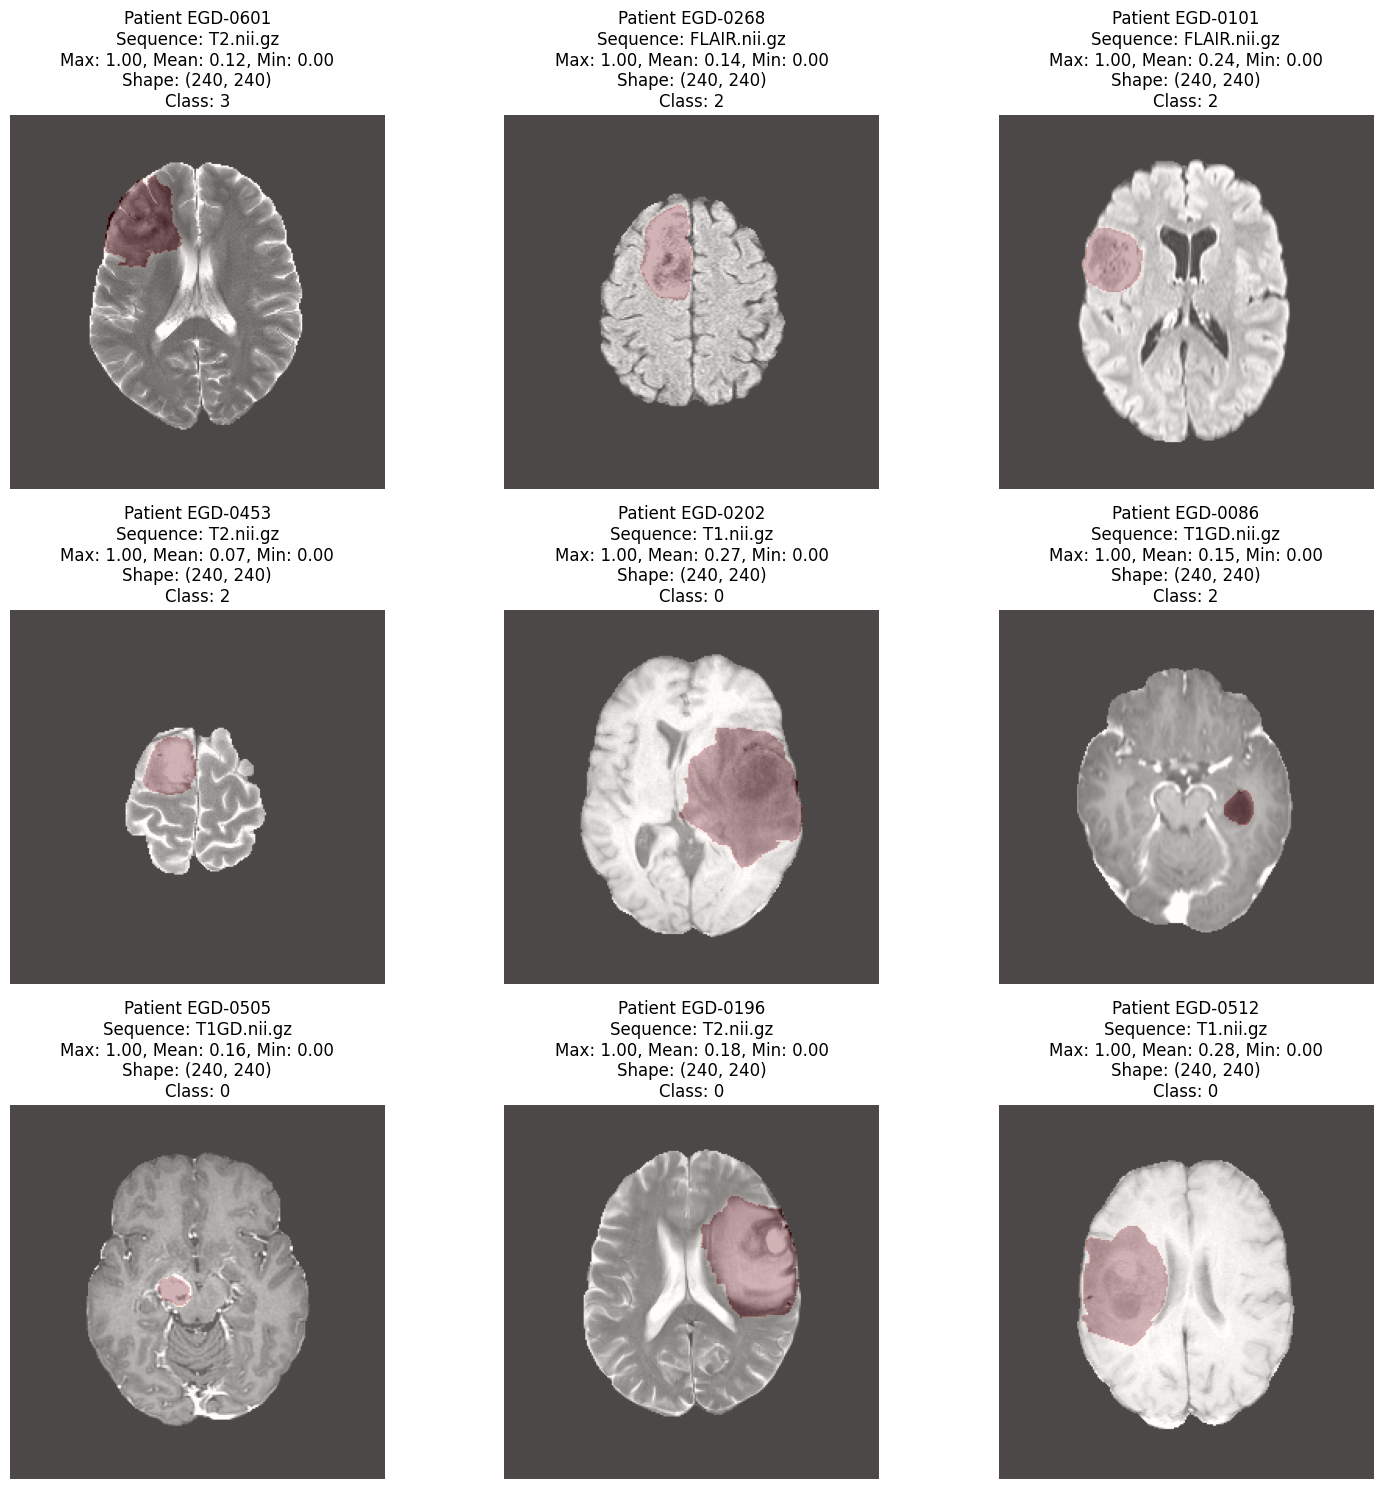

In [36]:
def rotate_and_normalize(image):
    # Rotate the image 90 degrees
    rotated_image = np.rot90(image, k=1)
    
    # Percentile normalization
    lower_percentile = np.percentile(rotated_image, 1)
    upper_percentile = np.percentile(rotated_image, 99)

    range_val = upper_percentile - lower_percentile

    normalized_image = np.clip(rotated_image, lower_percentile, upper_percentile)
    normalized_image = (normalized_image - lower_percentile) / (upper_percentile - lower_percentile)
    
    return normalized_image

def pad_image_to_size(image, desired_size=IMG_SIZE):
    """
    Pads a 2D (or 2D + channel) image to the desired_size x desired_size.
    The original image is centered, and extra pixels are padded equally on both sides.
    
    image: 2D array or 3D array (height, width, [channels])
    desired_size: target dimension for height and width
    """
    # If image has channels, separate out shape
    if len(image.shape) == 2:
        height, width = image.shape
        channels = None
    else:
        height, width, channels = image.shape
    
    # Compute how much to pad on each dimension
    pad_height = desired_size - height
    pad_width = desired_size - width
    
    if pad_height < 0 or pad_width < 0:
        raise ValueError("Image is larger than desired size. Resize or crop first.")

    # Pad equally on both sides
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    if channels is None:
        # Grayscale or single-channel
        padded_image = np.pad(
            image,
            ((pad_top, pad_bottom), (pad_left, pad_right)),
            mode='constant',
            constant_values=0
        )
    else:
        # Multi-channel
        padded_image = np.pad(
            image,
            ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
            mode='constant',
            constant_values=0
        )
    
    return padded_image


def visualize_random_patients_rotated_normalized(all_patients):
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    random_patients = random.sample(all_patients, 9)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, patient in enumerate(random_patients):
        ax = axes[i // 3, i % 3]
        sequences = [patient.t1, patient.t1c, patient.t2, patient.flair]
        sequence_path = random.choice([seq for seq in sequences if seq is not None])
        image = load_nifti_image(sequence_path)
        segmentation = load_nifti_image(patient.tumor_segmentation)
        slice_index = np.argmax(np.sum(segmentation, axis=(0, 1)))
        
        # Rotate and normalize the image and segmentation
        image_rotated_normalized = rotate_and_normalize(image[:, :, slice_index])
        image_resized = pad_image_to_size(image_rotated_normalized)
        segmentation_rotated = np.rot90(segmentation[:, :, slice_index], k=1)
        segmentation_resized = pad_image_to_size(segmentation_rotated)
        
        ax.imshow(image_resized, cmap='gray', alpha = 1)
        ax.imshow(segmentation_resized, cmap='Reds', alpha=0.3)
        ax.axis('off')

        max_value = np.max(image_resized)
        mean_value = np.mean(image_resized)
        min_value = np.min(image_resized)

        title = (
            f'Patient {patient.id}\n'
            f'Sequence: {sequence_path.name}\n'
            f'Max: {max_value:.2f}, Mean: {mean_value:.2f}, Min: {min_value:.2f}\n'
            f'Shape: {image_resized.shape}\n'
            f'Class: {patient.classification}'
        )

        ax.set_title(f'{title}')

    plt.tight_layout()
    plt.show()

visualize_random_patients_rotated_normalized(all_patients)

## Save images with largest slice as png

Get the unique segmentation classes used in the mask file

In [23]:
def show_segmentation_classes(patient):
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    segmentation = load_nifti_image(patient.tumor_segmentation)
    unique_classes = np.unique(segmentation)
    
    print(f"Unique segmentation classes for patient {patient.id}: {unique_classes}")

# Example usage for a random patient
random_patient = random.choice(all_patients)
show_segmentation_classes(random_patient)

Unique segmentation classes for patient EGD-0572: [0. 1.]


Okay the segmentation mask here simply shows wether there is a tumor or not, there's no further differentiation, which makes the following relatively easy.

In [32]:
def save_largest_tumor_slice(patient, output_folder):
    def load_nifti_image(path):
        return nib.load(str(path)).get_fdata()

    # Load segmentation and find the slice with the largest area of segmentation class 4
    segmentation = load_nifti_image(patient.tumor_segmentation)
    slice_index = np.argmax(np.sum((segmentation == 1) | (segmentation == 4), axis=(0, 1)))

    # Create output directory for the patient
    patient_output_folder = Path(output_folder) / patient.id
    patient_output_folder.mkdir(parents=True, exist_ok=True)

    # Save each sequence and the segmentation mask as PNG
    sequences = {
        't1': patient.t1,
        't1c': patient.t1c,
        't2': patient.t2,
        'flair': patient.flair
    }

    for sequence_name, sequence_path in sequences.items():
        if sequence_path is not None:
            image = load_nifti_image(sequence_path)
            image_slice = image[:, :, slice_index]
            image_rotated_normalized = rotate_and_normalize(image_slice)
            image_resized = pad_image_to_size(image_rotated_normalized)
            plt.imsave(patient_output_folder / f'{patient.id}_{sequence_name}.png', image_resized, cmap='gray')

    # Save the segmentation mask
    segmentation_slice = segmentation[:, :, slice_index]
    segmentation_mask = (segmentation_slice == 1).astype(np.uint8)  # Create a binary mask for class 4
    segmentation_rotated = np.rot90(segmentation_mask, k=1)
    segmentation_resized = pad_image_to_size(segmentation_rotated)
    plt.imsave(patient_output_folder / f'{patient.id}_mask.png', segmentation_resized, cmap='gray')

# Save largest tumor slice for all patients
for patient in tqdm(all_patients):
    save_largest_tumor_slice(patient, path_to_egd_png_slices)

100%|██████████| 151/151 [00:27<00:00,  5.58it/s]


Check if each folder contains 5 png files

In [15]:
def check_png_files_in_folder(folder_path):
    # Get all subfolders in the main folder
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

    # Check each subfolder for the number of PNG files
    for subfolder in subfolders:
        png_files = [f for f in os.listdir(subfolder) if f.endswith('.png')]
        if len(png_files) != 5:
            print(f"Subfolder {subfolder} contains {len(png_files)} PNG files instead of 5.")

# Check the path_to_upenn_png_slices folder
check_png_files_in_folder(path_to_egd_png_slices)

## Create TFRecord Files for patients

In [16]:
def serialize_example(image, label):
    """
    image: A NumPy array containing the image (could be shape (H, W, 5) or (H, W, 3, 5))
    label: Integer label (you can adapt this to your actual label)
    """
    # If 'image' is already a NumPy array, just flatten it:
    image_flattened = image.ravel()

    # Create a tf.train.Example
    tumor_example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'image': tf.train.Feature(float_list=tf.train.FloatList(value=image_flattened)),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }
        )
    )
    return tumor_example.SerializeToString()

def write_patient_to_tfrecord(
    patient_id,
    patient_folder,
    tfrecord_folder,
    label=0,
    is_rgb=False,
    compression_type="GZIP"
):
    """
    patient_id: Unique identifier for the patient (string or int).
    patient_folder: Path to the folder containing the 5 PNG images (T1, T1c, T2, Flair, mask).
    tfrecord_folder: Output folder for the TFRecord file.
    label: A label (int) for the example, can be adapted to your classification task.
    is_rgb: Whether to replicate each 2D slice into 3 channels. 
            - If False -> shape (H, W, 5)
            - If True  -> shape (H, W, 3, 5)
    """
    # Ensure output folder exists
    tfrecord_folder = Path(tfrecord_folder)
    tfrecord_folder.mkdir(parents=True, exist_ok=True)

    # Define the order of sequences you want to load
    sequence_names = ['t1', 't1c', 't2', 'flair', 'mask']

    # Gather all 5 images
    images = []
    for seq_name in sequence_names:
        png_path = Path(patient_folder) / f'{patient_id}_{seq_name}.png'
        if not png_path.exists():
            raise FileNotFoundError(f"Expected file {png_path} not found for patient {patient_id}")
        
        # Read in grayscale (single channel)
        # Resulting shape => (H, W)
        img = cv2.imread(str(png_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"cv2 could not read the file: {png_path}")
        
        # resize image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Convert to float32
        img = img.astype(np.float32)

        # If is_rgb=True, replicate the single channel to 3 channels
        # final shape => (H, W, 3)
        if is_rgb:
            img = np.stack([img, img, img], axis=-1)  # (H, W, 3)

        images.append(img)

    # Stack the 5 images along a new axis
    if is_rgb:
        # images is a list of 5 items, each (H, W, 3)
        # final shape => (H, W, 3, 5)
        final_image = np.stack(images, axis=-1)
    else:
        # images is a list of 5 items, each (H, W)
        # final shape => (H, W, 5)
        final_image = np.stack(images, axis=-1)

    # Write one example to a TFRecord
    tfrecord_filename = tfrecord_folder / f"{patient_id}_label_{label}.tfrecord"
    options = tf.io.TFRecordOptions(compression_type=compression_type)
    with tf.io.TFRecordWriter(str(tfrecord_filename), options=options) as writer:
        # Create a single Example for this patient
        example = serialize_example(final_image, label)
        writer.write(example)

    #print(f"Saved TFRecord for patient {patient_id} at {tfrecord_filename}")

def create_tfrecords_for_all_patients(
    png_root_folder,
    tfrecord_folder,
    is_rgb=False
):
    """
    Loop over all patients, read their 5 PNG slices, 
    and write one TFRecord file per patient.
    
    png_root_folder: The folder where each patient's subfolder is located.
                     Inside each subfolder there should be 5 PNG images.
    tfrecord_folder: Output folder for the TFRecord files.
    is_rgb: Whether to replicate each 2D slice into 3 channels. 
    """

    patient_ids = [
        f.name for f in Path(png_root_folder).iterdir()
        if f.is_dir()
    ]

    for pid in tqdm(patient_ids):
        patient_folder = Path(png_root_folder) / str(pid)
        
        # get label from patient
        label = [patient.classification for patient in all_patients if patient.id == pid][0]
        if label is None:
            label = 0
            print(f"Patient {pid} has no label, using default label 0")

        write_patient_to_tfrecord(
            patient_id=pid,
            patient_folder=patient_folder,
            tfrecord_folder=tfrecord_folder,
            label=label,
            is_rgb=is_rgb
        )


In [17]:
os.makedirs(path_to_egd_rgb_tfrs, exist_ok=True)
os.makedirs(path_to_egd_gray_tfrs, exist_ok=True)

# Create TFRecords in grayscale mode:
create_tfrecords_for_all_patients(
    png_root_folder=path_to_egd_png_slices,
    tfrecord_folder=path_to_egd_gray_tfrs,
    is_rgb=False,
)

# Optionally create TFRecords in RGB mode:
create_tfrecords_for_all_patients(
    png_root_folder=path_to_egd_png_slices,
    tfrecord_folder=path_to_egd_rgb_tfrs,
    is_rgb=True,
)

100%|██████████| 151/151 [00:20<00:00,  7.45it/s]


## Read TFRecord Files

Label: 3
(240, 240, 3, 5)


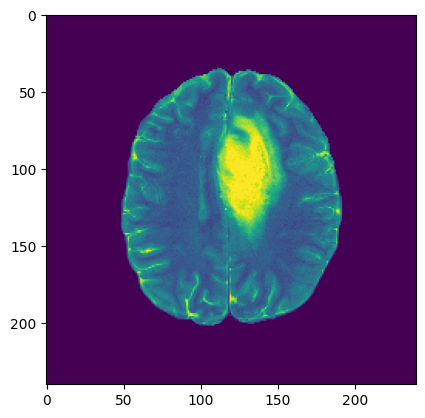

In [46]:
path_to_testing_tfr = "/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_tfrs/rgb_tfrs/EGD-0143.tfrecord"
rgb = True

num_images = 5 # 4 sequences + 1 mask

image_shape = []

if rgb: # rgb images need three channels
    image_shape = [240, 240, 3, num_images]
else: # gray scale images don't
    image_shape = [240, 240, num_images]

feature_description = {
    "image": tf.io.FixedLenFeature(image_shape, tf.float32),
    "label": tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def parse(serialize_patient):
    example = tf.io.parse_single_example(serialize_patient, feature_description)

    image = example["image"]
    image = tf.reshape(image, image_shape)
    
    return image, example["label"]

dataset = tf.data.TFRecordDataset([path_to_testing_tfr], compression_type="GZIP")
parsed_dataset = dataset.map(parse)

test_image = parsed_dataset.take(1)
for image, label in test_image:
    print(f"Label: {label.numpy()}")
    numpy_image = image.numpy()
    print(numpy_image.shape)
    if rgb:
        plt.imshow(numpy_image[:,:,2,2])
    else:
        plt.imshow(numpy_image[:,:,1])

## Dataset Summary

In [50]:
# count classifications in all_patients
classification_counts = {}
for patient in all_patients:
    if patient.classification in classification_counts:
        classification_counts[patient.classification] += 1
    else:
        classification_counts[patient.classification] = 1

# rename classes
# - 0: Glioblastoma, IDH-wildtype
# - 1: Astrocytoma, IDH-wildtype
# - 2: Astrocytoma, IDH-mutant
# - 3: Oligodendroglioma, IDH-mutant, 1p/19q-codeleted
classification_counts["Glioblastoma"] = classification_counts.pop(0)
classification_counts["Astrocytoma, IDH-wildtype"] = classification_counts.pop(1)
classification_counts["Astrocytoma, IDH-mutant"] = classification_counts.pop(2)
classification_counts["Oligodendroglioma, IDH-mutant, 1p/19q-codeleted"] = classification_counts.pop(3)

for classification, count in classification_counts.items():
    print(f"{classification}: {count}")

print()
print(f"Total number of patients: {len(all_patients)}")

Glioblastoma: 55
Astrocytoma, IDH-wildtype: 11
Astrocytoma, IDH-mutant: 43
Oligodendroglioma, IDH-mutant, 1p/19q-codeleted: 42

Total number of patients: 151
